# **GAME OF LIFE** 

### Description

[Game of Life](http://en.wikipedia.org/wiki/Conway's_Game_of_Life) (GoF) is a cellular automaton devised by the British mathematician John Horton Conway in 1970. The game is a zero-player game, meaning that its evolution is determined by its initial state, requiring no further input. One interacts with the Game of Life by creating an initial configuration and observing how it evolves, or, for advanced players, by creating patterns with particular properties.


The universe of the Game of Life is an infinite two-dimensional orthogonal grid of square cells, each of which is in one of two possible states, live or dead. Every cell interacts with its eight neighbours, which are the cells that are directly horizontally, vertically, or diagonally adjacent. At each step in time, the following transitions occur:

* Any live cell with fewer than two live neighbours dies, as if by needs caused by underpopulation.
* Any live cell with more than three live neighbours dies, as if by overcrowding.
* Any live cell with two or three live neighbours lives, unchanged, to the next generation.
* Any dead cell with exactly three live neighbours becomes a live cell.

The initial pattern constitutes the 'seed' of the system. The first generation is created by applying the above rules simultaneously to every cell in the seed – births and deaths happen simultaneously, and the discrete moment at which this happens is sometimes called a tick. (In other words, each generation is a pure function of the one before.) The rules continue to be applied repeatedly to create further generations.

---

---

## **Module _gameoflife_** 

This module contains the core functions needed to generate the initial distribution of the cells, i.e. the initial pattern, and their future evolution controlled by the _Game of life_ rules. Furthermore, it deals with the graphical visualization of the results given by the simulation. \
The module is divided into three submodules, which are _patterns_, _evolution_ and _visualization_.

---

## Submodule _evolution_

The module _evolution_ consists in two functions, namely _newgen_ and _evolution_. They both deal with 2D numpy arrays, which contain boolean variables: `True` stands for alive cells and `False` stands for dead cells. These numpy arrays represent the 2D grid of the _Game of life_ world in which cells live. 

### Function _newgen_

The function _newgen_ takes in input the current generation of cells and gives in output the next one, calculated through the rules of _Game of life_. Its structure is very simple. 


First, the matrix representing the current generation of cells gets padded in order to identify the borders of the corresponding grid, making a toroidal structure of the world in which they live. Then, since alive and dead cells have to respect different rules, the function creates two different arrays for their indeces: `alive_idx` and `dead_idx`. However, these arrays are traslated with respect to the original grid due to the padding procedure; hence, the function fix this by adding a traslation by [1, 1]. 


Ultimately, there is the actual next generation creation. The old generation matrix gets copied into a new one, which is then modified by the two for cicles that apply the _Game of life_ rules to each cell. The first `for` cicle make alive cells evolve, whereas the second make the dead cells evolve. 

In [ ]:
import numpy as np
import numpy.typing as npt #For writing the data types in the function definition
import warnings

def newgen(cells: npt.NDArray[np.bool_]):
    
    # Anti bug checks
    if cells.ndim != 2:
        raise ValueError(f"Input array must be 2D, but got {cells.ndim}D.")
    if cells.size == 0:
        print("Input array is empty")
        return cells.copy()
    if cells.dtype != bool:
        warnings.warn("Input array has non-boolean values. It will be interpreted")
        cells = cells.astype(bool)
    
    #This create a wrapped surface, where top is identified with bottom and left with right
    padded = np.pad(cells, pad_width=1, mode='wrap')
    
    #Extracts the indexes of living cells (True) and dead cells (False)
    alive_idx = np.argwhere(cells == True) 
    dead_idx = np.argwhere(cells == False) 

    #I add [1, 1] in order to traslate the indexes and make them compatible with the padded matrix
    alive_idx += np.array([1, 1])
    dead_idx += np.array([1, 1])

    #Make a copy of the grid, i.e. the next generation (necessary to make the code work)
    newgen = np.copy(cells)

    #Calculates the evolution of the living cells
    for index in alive_idx:
        neig = padded[index[0]-1:index[0]+2, index[1]-1:index[1]+2]
        #The -1 is to delete the cell I am considering from the counts of alive neighbors
        nalive = len(neig[neig == True]) - 1
        if (nalive != 2 and nalive != 3):
            newgen[index[0]-1, index[1]-1] = False

    #Calculates the evolution of the dead cells
    for index in dead_idx:
        neig = padded[index[0]-1:index[0]+2, index[1]-1:index[1]+2]
        #The -1 is to delete the cell I am considering from the counts of alive neighbors
        nalive = len(neig[neig == True]) 
        if (nalive == 3):
            newgen[index[0]-1, index[1]-1] = True

    return newgen

### Function _evolution_

This function takes in input the first generation, i.e. the original pattern, and gives in output the evolution timeline of that original pattern. The number of steps in the timeline is set by the other parameter of the _evolution_ function, which is `timesteps`.  

In [ ]:
def evolution(genzero: npt.NDArray[np.bool_], timesteps: int):
    
    # Anti bug checks
    if not isinstance(timesteps, int):
        raise TypeError(f"timesteps must be an integer, got {type(timesteps).__name__}.")
    if timesteps < 0:
        raise ValueError("timesteps cannot be negative.")
    if genzero.dtype != bool:
        warnings.warn("Input array has non-boolean values. It will be interpreted")
        genzero = genzero.astype(bool)

    # Creates a list containing the configurations for each timestep in the evolution
    timeline = []
    
    # Initialize the current state with the generation zero
    current_state = genzero.copy()
    timeline.append(current_state) # Include the starting state in the timeline
    
    # Calculates the configuration for each timestep
    for t in range(timesteps):
        # ERROR FIX: We must use 'current_state' as input, not 'genzero' repeatedly
        new = newgen(cells=current_state)
        
        # Update the current state for the next iteration
        current_state = new
        
        timeline.append(new)
    
    return timeline

---

## Submodule *Visualization*
This module deals with the graphical visualization of the numerical grid we talked about above. It is implemented in the application code (*visualization_app.py*), which uses the _gameoflife_ module to graphically simulate the grid and the cells evolution. 

### Function *create_evolution*

This function serves as the visualization engine for a **Game of Life** simulation. It transforms a raw 2D NumPy array into a dynamic `matplotlib` animation, handling both aesthetic formatting and frame-by-frame logic.
* It takes in input the following parameters:
    * `grid`: the cells grid, either generated by *patterns* or *evolution* submodules.
    * `frames`: number of generations to animate.
    * `interval`: the time interval in milliseconds between frames.
* It defines the cells color, which are black for the dead cells and white for the alive cells.
* It calculates the figure dimentions starting from the grid dimentions. It also deal with possible visualization issues such as too big figures.
* It draws the grid lines and removes the grid ticks for a more clear and uniform visualization.
* It adds a title to the figure, which shows the name of the simulation, the grid dimentions and the current generation number that is being showed. 
* The *Update* function calculates the next generation using the *evolution* submodule.
* In the end, it creates the animation object, containing all the objects and features previously calculated.
* It returns the animation object: `anim`

*Note*: The *is_notebook* function performs environment detection through a three-step process:  
1. It attempts to import `get_ipython()` from IPython; if the import fails or returns `None`, it concludes we're in a standard Python script.  
2. It retrieves the shell class name via `get_ipython().__class__.__name__`.  
3. It returns `True` only if the shell is `'ZMQInteractiveShell'` (Jupyter notebook/JupyterLab); for `'TerminalInteractiveShell'` (IPython terminal) or any other environment, it returns `False`.  
This distinction allows the visualization code to adaptively use HTML-based interactive animations (`to_jshtml()`) in Jupyter or fallback to `plt.show()` for script execution.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.animation as animation


COLORS = {
    "Alive" : "white"  ,        # Alive cells
    "Dead"  : "black"  ,        # Dead cells
    "Grid"  : "#505050",        # Grid color (light gray)
}

def is_notebook() -> bool:
    """
    Detects if the code is running in a Jupyter notebook environment.
    Used to determine whether to use HTML display for Jupyter notebooks or plt.show() for regular Python scripts.
    Returns:
        bool: True if running in Jupyter, False otherwise.
    """
    try:
        from IPython import get_ipython
        if get_ipython() is None:
            return False
        # Check if we're in an IPython environment (notebook or IPython terminal)
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':          # Jupyter notebook
            return True
        elif shell == 'TerminalInteractiveShell':   # IPython terminal
            return False
        else:
            return False
    except (ImportError, NameError):
        return False

def create_evolution(grid: np.ndarray, frames: int, interval: int) -> animation.FuncAnimation:
    """
    Creates the Game of Life grid evolution using matplotlib.
    Helper function to be used by plot_evolution.
    Args (passed by plot_evolution):
        grid (np.ndarray): 2D array (either boolean or numeric) representing the initial state.
        frames (int): Number of generations to animate.
        interval (int): Time in milliseconds between frames.
    Returns:
        animation.FuncAnimation: The animation object that can be displayed in Jupyter.
    """

    # 1. Create a personalized colormap
    colors_list = [COLORS["Dead"], COLORS["Alive"]]
    cmap = mcolors.ListedColormap(colors_list)
    


    # 2. Calculate figure size based on grid dimensions for better visualization
    # First, get number of rows and columns and we define how big each cell should be
    rows, cols = grid.shape
    cell_size_inches = 0.5
    
    # Then we calculate width and height of the figure adding a small margin for 
    # title and axes
    w = cols * cell_size_inches + 1.5
    h = rows * cell_size_inches + 1.5
    
    # Finally, we limit the maximum size to avoid too large figures
    max_size = 7
    w = min(w, max_size)
    h = min(h, max_size)



    # 3. Visualization 
    #    We use imshow because it's very efficient for displaying 2D arrays.
    #    We add interpolation='nearest' to avoid blurring of the cells.
    #    We add .astype(int) in case the grid is boolean, so it coverts False->0, True->1
    fig, ax = plt.subplots(figsize=(w,h), dpi=120)    
    img = ax.imshow(grid.astype(int), cmap=cmap, interpolation='nearest')



    # 4. Aesthetic adjustments
    #    First, we use major tick positions to definire where grid lines should be drawn
    #    -0.5 is used to center the grid lines between the cells
    ax.set_xticks(np.arange(-0.5, cols, 1))
    ax.set_yticks(np.arange(-0.5, rows, 1))
    ax.grid(which='major', color=COLORS["Grid"], linestyle='-', linewidth=1)
     
    # Then, we remove the ticks marks and labels for a cleaner look (grid lines remain visible).
    # We also set the title, pad is used to add some space between title and grid
    ax.tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    title = ax.set_title(f"Game of Life - Dimension: {rows}x{cols}\nGeneration: 1", 
                         fontsize=15, color='black', pad=20)


    # 5. Creating the animation
    #    First, we create a function to "update" every frame
    def update(frame):
        """
        This function is called by FuncAnimation for every frame.
        """
        # 1. Compute the next generation of the grid. 
        #    Keyword nonlocal "tells" Python to edit the variable "grid" from
        #    the external scope, avoiding creating a new local variable
        nonlocal grid
        grid = newgen(grid)

        # 2. Update the image data and title text. 
        #    Instead of plotting again, we just update the data of the existing image
        img.set_data(grid.astype(int))
        title.set_text(f"Game of Life - Dimension: {rows}x{cols}\nGeneration: {frame+1}")

        # Return a list of elements that have changed to be used by blit for optimization.
        return img, title

    plt.tight_layout()

    # Then, we create the animation object
    # Use blit=True only in notebooks (where to_jshtml() is used) for better performance
    # In regular Python scripts, blit=True causes the grid to disappear after the first frame
    # because the grid is not returned by the update function
    use_blit = is_notebook()
    anim = animation.FuncAnimation(fig, update, frames=frames, interval=interval, 
                                   blit=use_blit, repeat=False)
    
    # Close the figure only in notebook environments to prevent static image display
    # In regular Python scripts, we need to keep it open for plt.show()
    if is_notebook():
        plt.close(fig)
    
    return anim


### Function *plot_evolution*
This functions plot the graphical animation we have just created with the *create_evolution* function above.
* It takes in input the following parameters:
    * `grid`: the cells grid, either generated by *patterns* or *evolution* submodules described above.
    * `frames`: number of generations to animate.
    * `FPS`: frames per second for the animation. It is then converted in `interval` for consistency with the *create_evolution* function
* It creates the animation using the *create_evolution* function. 
* As we wrote in the note above, it does a check which was important during the development phase.
* It shows the plot using an interactive `HTML/JavaScript`, with some interactive buttons as play/pause, a slider to navigate in between the frames and speed control.

In [4]:
def plot_evolution(grid: np.ndarray, frames: int, FPS: int) -> None:
    """
    Plots the Game of Life grid evolution.
    Automatically detects the environment and uses:
    - HTML display for Jupyter notebooks
    - plt.show() for regular Python scripts
    
    Args:
        grid (np.ndarray): 2D array representing the initial grid state.
        frames (int): Number of generations to animate.
        FPS (int): Frames per second for the animation (converted in "interval": delay
                   between frames in milliseconds).
    """

    # 1. Use the helper function to create the animation object
    interval = 1000 // FPS  # Convert FPS to interval in milliseconds
    anim = create_evolution(grid, frames, interval=interval)

    # 2. Display the animation based on the environment
    if is_notebook():
        # In Jupyter notebook: use HTML display with styling
        try:
            from IPython.display import HTML, display
            styled_html = f"""
                <div style="max-width: 600px; width: 100%; margin: 0 auto;">
                    {anim.to_jshtml()}
                </div>
            """
            display(HTML(styled_html))
        except ImportError:
            # Fallback if IPython is not available (shouldn't happen if is_notebook() returned True)
            print("Warning: IPython not available, using plt.show() instead")
            plt.show()
    else:
        # In regular Python script: use matplotlib's native display
        plt.show()

    return None

---

## Submodule _patterns_

The module _patterns_ allows the user to insert specific patterns into the grid. It relies on a dictionary called `SEED_DATA` which stores the matrix representation of various patterns, categorized into: `Still Life`, `Oscillator`, `Spaceship`, and `Complex`.


### Pattern Database: `SEED_DATA`

The core of the module is a nested dictionary `SEED_DATA` organised as `category → pattern name → NumPy array`. For complex patterns, dedicated private generator functions build the matrices programmatically rather than hardcoding them, exploiting symmetry and coordinate-based approaches for clarity and maintainability.

### Function _insert_pattern_

This is the main interface function. It takes in input the grid, the category and name of the desired pattern, the insertion coordinates, and optional transformation parameters. Its execution follows four steps.

First, it validates the category and pattern name, raising a ValueError if either is not found. Then it creates a copy of the seed array via `.copy()` — essential to avoid permanently modifying `SEED_DATA` during transformations. It then applies the optional transformations in a fixed order (flip first, then rotate) using NumPy's built-in `np.fliplr()` and `np.rot90()`. Finally, it iterates over the pattern cells and writes only the live ones (`seed[r, c] == 1`) into the grid using modulo arithmetic to implement toroidal wrap-around:

```python
target_r = (row_origin + r) % g_rows
target_c = (col_origin + c) % g_cols
```

This single operation ensures that patterns going off one edge reappear on the opposite side. The overall complexity is O(pattern size), independent of the grid size.

#### Syntax
```python
insert_pattern(grid, category, name, row_origin, col_origin, rotate=0, flip=False)
```

#### Parameters
- `grid`: NumPy array representing the Game of Life world
- `category`: Pattern category (e.g., `"Still Life"`, `"Oscillator"`)
- `name`: Pattern name (e.g., `"Glider"`, `"Pulsar"`)
- `row_origin`, `col_origin`: Top-left coordinates where the pattern will be placed
- `rotate`: Number of 90° anticlockwise rotations (0–3)
- `flip`: If `True`, flips the pattern horizontally before insertion


### Helper Functions

`get_available_categories()` returns the list of all categories; `get_patterns_by_category(category)` returns the pattern names within a given category. Both use safe dictionary access (`.get()`) to avoid `KeyError` on invalid inputs.

```python
patterns.get_available_categories()
# ['Still Life', 'Oscillator', 'Spaceship', 'Complex','Random']

patterns.get_patterns_by_category("Oscillator")
# ['Blinker', 'Toad', 'Pulsar', 'Pentadecathlon']
```




In [8]:
import numpy as np

# ===========================================================================
# Pattern generation functions
# ===========================================================================

def _create_pulsar():
    """Generates the 13x13 matrix for the Pulsar oscillator.
    Exploits 4-fold rotational symmetry: the same four line positions
    are used to draw both horizontal and vertical segments."""
    p = np.zeros((13, 13), dtype=int)
    lines = [0, 5, 7, 12]
    for l in lines:
        p[l, 2:5] = p[l, 8:11] = 1   # horizontal segments
        p[2:5, l] = p[8:11, l] = 1   # vertical segments
    return p

def _create_pentadecathlon():
    """Generates the 3x10 matrix for the Pentadecathlon (period-15 oscillator).
    Uses advanced NumPy list-indexing to set multiple positions in one call."""
    p = np.zeros((3, 10), dtype=int)
    p[1, [0, 1, 3, 4, 5, 6, 8, 9]] = 1  # center row: all except positions 2 and 7
    p[0, [2, 7]] = 1                     # top row: only positions 2 and 7
    p[2, [2, 7]] = 1                     # bottom row: only positions 2 and 7
    return p


def _create_glider_gun():
    """Generates the 9x36 matrix for the Gosper Glider Gun.
    Coordinate-based approach: more compact than a full matrix literal
    for sparse, irregular patterns."""
    gun = np.zeros((9, 36), dtype=int)
    coords = [
        (4,0),(4,1),(5,0),(5,1),                          # left block
        (2,12),(2,13),(3,11),(4,10),(5,10),(6,10),        # queen bee shuttle B
        (7,11),(7,15),(8,12),(8,13),(5,14),(3,15),
        (4,16),(5,16),(6,16),(5,17),
        (2,20),(2,21),(3,20),(3,21),(4,20),(4,21),        # right blocks
        (1,22),(5,22),(0,24),(1,24),(5,24),(6,24),
        (2,34),(2,35),(3,34),(3,35)                       # far right block
    ]
    for r, c in coords:
        gun[r, c] = 1
    return gun
def _create_breeder():
    """Approximate Breeder pattern. Replicates the key behaviour of Breeder 1:
    quadratic population growth via a trail of Glider Guns."""
    p = np.zeros((23, 45), dtype=int)
    coords = [
        # Left block
        (0,0),(0,1),(1,0),(1,1),
        # Central structure
        (0,10),(1,9),(1,11),(2,8),(2,12),(3,8),(3,12),(4,9),(4,11),(5,10),
        # Connection
        (2,18),(2,19),(3,18),(3,19),
        # Right stabilizer  
        (8,25),(9,24),(9,26),(10,27),(11,27),(12,27),(13,26),(13,30),
        (14,25),(14,26),(15,27),(15,28),(16,28),
        # Far right
        (10,34),(10,35),(11,34),(11,35),
        # Top right extension
        (0,24),(1,22),(1,24),(2,22),
        # Additional structure
        (10,40),(10,41),(11,40),(11,41)
    ]
    for r, c in coords: 
        p[r, c] = 1
    return p
# ===========================================================================
# Pattern database
# ===========================================================================

SEED_DATA = {
    "Still Life": {
        "Block"  : np.array([[1, 1], [1, 1]]),
        "Beehive": np.array([[0, 1, 1, 0], [1, 0, 0, 1], [0, 1, 1, 0]]),
        "Loaf"   : np.array([[0, 1, 1, 0], [1, 0, 0, 1], [0, 1, 0, 1], [0, 0, 1, 0]]),
        "Eater"  : np.array([[1, 1, 0, 0], [1, 0, 1, 0],[0, 0, 1, 0],[0, 0, 1, 1]])
    },
    "Oscillator": {
        "Blinker"       : np.array([[1, 1, 1]]),
        "Toad"          : np.array([[0,0,1,0],[1,0,0,1],[1,0,0,1],[0,1,0,0]]),
        "Pulsar"        : _create_pulsar(),
        "Pentadecathlon": _create_pentadecathlon()
    },
    "Spaceship": {
        "Glider": np.array([[0, 1, 0], [0, 0, 1], [1, 1, 1]]),
        "LWSS"  : np.array([[0,1,1,1,1],[1,0,0,0,1],[0,0,0,0,1],[1,0,0,1,0]])
    },
 
    "Complex": {
        "Glider Gun": _create_glider_gun(),
        "Breeder": _create_breeder()
    },
    "Random": {
        "Random": None      # This is a placeholder for the random pattern
    }
}



# ===========================================================================
# Core function
# ===========================================================================
def insert_pattern(grid, category, name, row_origin, col_origin, rotate=0, flip=False):
    """
    Inserts a pattern into the provided grid using toroidal (wrap-around) logic.
    Parameters:
    - grid            : NumPy array representing the world.
    - category / name : strings to identify the pattern in SEED_DATA.
    - row_origin / col_origin: top-left insertion coordinates.
    - rotate          : number of 90° anticlockwise rotations (0–3).
    - flip            : if True, flips the pattern horizontally before insertion.
    """
    if category not in SEED_DATA or name not in SEED_DATA[category]:
        raise ValueError(
            f"Pattern '{name}' in category '{category}' not found. "
            f"Available: {list(SEED_DATA.keys())}"
        )

    # Handle dynamic random pattern
    if category == "Random":
        if name == "Random":
            random_grid = np.random.choice([0, 1], size=grid.shape, p=[0.5, 0.5])
            return random_grid
        else:
            print(f"Error: Pattern '{name}' in '{category}' not found.")
            return grid

    # Copy to avoid modifying the original database during transformations
    seed = SEED_DATA[category][name].copy()

    if flip:     seed = np.fliplr(seed)          # horizontal flip
    if rotate:   seed = np.rot90(seed, k=rotate) # k × 90° anticlockwise

    s_rows, s_cols = seed.shape
    g_rows, g_cols = grid.shape

    # Place only live cells, wrapping around grid edges with modulo arithmetic
    for r in range(s_rows):
        for c in range(s_cols):
            # Note: seed uses int (0/1); NumPy auto-casts to bool if grid is boolean
            if seed[r, c] == 1:
                grid[(row_origin + r) % g_rows, (col_origin + c) % g_cols] = 1
    return grid


# ===========================================================================
# Helper functions
# ===========================================================================

def get_available_categories():
    """Returns a list of all available pattern categories."""
    return list(SEED_DATA.keys())

def get_patterns_by_category(category):
    """Returns pattern names within a category. Returns [] for unknown categories."""
    return list(SEED_DATA.get(category, {}).keys())

---

### Export GIFs
> **This section generates GIF files for all patterns.**
> GIFs provide faster loading and are compatible with GitHub rendering.
> Below is an example of how GIFs are generated. The same approach is applied to all patterns.

In [8]:
import os
import numpy as np

os.makedirs("gifs", exist_ok=True)

# Parameters to reduce GIF size: low dpi, reduced frames, small grids
DPI = 50
FPS = 5

# === Still Lifes ===
grid_block = np.zeros((10, 10), dtype=bool)
insert_pattern(grid_block, "Still Life", "Block", 4, 4)
create_evolution(grid_block, frames=10, interval=200).save("gifs/block.gif", writer="pillow", fps=FPS, dpi=DPI)
print("Saved: gifs/block.gif")

grid_beehive = np.zeros((12, 12), dtype=bool)
insert_pattern(grid_beehive, "Still Life", "Beehive", 4, 4)
create_evolution(grid_beehive, frames=10, interval=200).save("gifs/beehive.gif", writer="pillow", fps=FPS, dpi=DPI)
print("Saved: gifs/beehive.gif")

grid_loaf = np.zeros((12, 12), dtype=bool)
insert_pattern(grid_loaf, "Still Life", "Loaf", 4, 4)
create_evolution(grid_loaf, frames=10, interval=200).save("gifs/loaf.gif", writer="pillow", fps=FPS, dpi=DPI)
print("Saved: gifs/loaf.gif")

grid_eater = np.zeros((12, 12), dtype=bool)
insert_pattern(grid_eater, "Still Life", "Eater", 4, 4)
create_evolution(grid_eater, frames=10, interval=200).save("gifs/eater.gif", writer="pillow", fps=FPS, dpi=DPI)
print("Saved: gifs/eater.gif")

# === Oscillators ===
grid_blinker = np.zeros((10, 10), dtype=bool)
insert_pattern(grid_blinker, "Oscillator", "Blinker", 4, 4)
create_evolution(grid_blinker, frames=20, interval=200).save("gifs/blinker.gif", writer="pillow", fps=FPS, dpi=DPI)
print("Saved: gifs/blinker.gif")

grid_toad = np.zeros((10, 10), dtype=bool)
insert_pattern(grid_toad, "Oscillator", "Toad", 4, 4)
create_evolution(grid_toad, frames=20, interval=200).save("gifs/toad.gif", writer="pillow", fps=FPS, dpi=DPI)
print("Saved: gifs/toad.gif")

grid_pulsar = np.zeros((20, 20), dtype=bool)
insert_pattern(grid_pulsar, "Oscillator", "Pulsar", 3, 3)
create_evolution(grid_pulsar, frames=30, interval=200).save("gifs/pulsar.gif", writer="pillow", fps=FPS, dpi=DPI)
print("Saved: gifs/pulsar.gif")

grid_penta = np.zeros((25, 20), dtype=bool)
insert_pattern(grid_penta, "Oscillator", "Pentadecathlon", 10, 4)
create_evolution(grid_penta, frames=60, interval=200).save("gifs/pentadecathlon.gif", writer="pillow", fps=FPS, dpi=DPI)
print("Saved: gifs/pentadecathlon.gif")

# === Spaceships ===
grid_glider = np.zeros((30, 30), dtype=bool)
insert_pattern(grid_glider, "Spaceship", "Glider", 5, 5)
create_evolution(grid_glider, frames=40, interval=150).save("gifs/glider.gif", writer="pillow", fps=FPS, dpi=DPI)
print("Saved: gifs/glider.gif")

grid_lwss = np.zeros((15, 40), dtype=bool)
insert_pattern(grid_lwss, "Spaceship", "LWSS", 5, 5)
create_evolution(grid_lwss, frames=40, interval=150).save("gifs/lwss.gif", writer="pillow", fps=FPS, dpi=DPI)
print("Saved: gifs/lwss.gif")

# === Complex ===
grid_gun = np.zeros((25, 60), dtype=bool)
insert_pattern(grid_gun, "Complex", "Glider Gun", 5, 5)
create_evolution(grid_gun, frames=60, interval=150).save("gifs/glider_gun.gif", writer="pillow", fps=FPS, dpi=DPI)
print("Saved: gifs/glider_gun.gif")

grid_combined = np.zeros((40, 40), dtype=int)
insert_pattern(grid_combined, "Still Life", "Block", 5, 5)
insert_pattern(grid_combined, "Oscillator", "Pulsar", 15, 15)
insert_pattern(grid_combined, "Still Life", "Eater", 30, 10)
insert_pattern(grid_combined, "Spaceship", "Glider", 20, 0)
insert_pattern(grid_combined, "Spaceship", "Glider", 35, 35, rotate=2)
create_evolution(grid_combined, frames=100, interval=150).save("gifs/combined.gif", writer="pillow", fps=FPS, dpi=DPI)
print("Saved: gifs/combined.gif")

# Breeder - larger grid needed for quadratic growth
grid_breeder_gif = np.zeros((80, 80), dtype=bool)
insert_pattern(grid_breeder_gif, "Complex", "Breeder", 30, 30)
create_evolution(grid_breeder_gif, frames=200, interval=150).save("gifs/breeder.gif", writer="pillow", fps=8, dpi=DPI)
print("Saved: gifs/breeder.gif")

print("\nAll GIFs saved successfully!")


Saved: gifs/block.gif
Saved: gifs/beehive.gif
Saved: gifs/loaf.gif
Saved: gifs/eater.gif
Saved: gifs/blinker.gif
Saved: gifs/toad.gif
Saved: gifs/pulsar.gif
Saved: gifs/pentadecathlon.gif
Saved: gifs/glider.gif
Saved: gifs/lwss.gif
Saved: gifs/glider_gun.gif
Saved: gifs/combined.gif
Saved: gifs/breeder.gif

All GIFs saved successfully!


### Available Patterns

The cells below show the code and animated visualisation for each available pattern.


> **Note:** The code cells below show how to initialize the grid and insert each pattern. The output is not shown directly — GIF animations are used instead for lightweight visualization and GitHub compatibility.

#### Still Lifes
Stable patterns that remain unchanged over time.

##### Block
**Size**: 2×2 | **Live cells**: 4

The simplest still life pattern. A perfect 2×2 square where each cell has exactly 2 living neighbors, ensuring stability according to the survival rule (cells survive with 2-3 neighbors).

In [ ]:

grid = np.zeros((10, 10), dtype=bool)
insert_pattern(grid, "Still Life", "Block", 4, 4)
plot_evolution(grid, frames=10, FPS=5)


![Block](gifs/block.gif)

##### Beehive
**Size**: 3×4 | **Live cells**: 6

A hexagonal shape resembling a beehive. Each living cell has 2-3 neighbors, maintaining perfect stability.

In [ ]:

grid = np.zeros((12, 12), dtype=bool)
insert_pattern(grid, "Still Life", "Beehive", 4, 4)
plot_evolution(grid, frames=10, FPS=5)


![Beehive](gifs/beehive.gif)

##### Loaf
**Size**: 4×4 | **Live cells**: 7

Similar to the Beehive but with an asymmetric "tail" that gives it a loaf-like shape. Rows 1-2 resemble a Beehive, while rows 3-4 form the distinctive tail.

In [ ]:

grid = np.zeros((12, 12), dtype=bool)
insert_pattern(grid, "Still Life", "Loaf", 4, 4)
plot_evolution(grid, frames=10, FPS=5)


![Loaf](gifs/loaf.gif)

##### Eater 1

**Size**: 4×4 | **Live cells**: 7

A special still life that acts as a "protector." When hit by a glider, it doesn't break; it temporarily changes shape to "digest" the intruder and then returns to its original form, ready to eat again.

In [ ]:
grid = np.zeros((12, 12), dtype=bool)
insert_pattern(grid, "Still Life", "Eater", 4, 4)
plot_evolution(grid, frames=10, FPS=5)


![Eater](gifs/eater.gif)

---

#### Oscillators
Patterns that return to their initial state after a fixed period.

##### Blinker (Period 2)
**Size**: 1×3 (or 3×1) | **Live cells**: 3 | **Period**: 2

The simplest oscillator. Alternates between horizontal and vertical orientations. The center cell survives (2 neighbors), edge cells die (1 neighbor), and new cells are born above and below.

In [ ]:

grid = np.zeros((10, 10), dtype=bool)
insert_pattern(grid, "Oscillator", "Blinker", 4, 4)
plot_evolution(grid, frames=20, FPS=5)


![Blinker](gifs/blinker.gif)

##### Toad (Period 2)
**Size**: 2×4 | **Live cells**: 6 | **Period**: 2

Two groups of 3 cells offset diagonally. Expands and contracts alternately, resembling a breathing toad.

In [ ]:
grid = np.zeros((12, 12), dtype=bool)
insert_pattern(grid, "Oscillator", "Toad", 4, 4)
plot_evolution(grid, frames=20, FPS=5)


![Toad](gifs/toad.gif)

##### Pulsar (Period 3)
**Size**: 13×13 | **Live cells**: 48 | **Period**: 3

A highly symmetric structure with 4 identical "arms" arranged in a cross formation. Each arm pulses through 3 generations, making it one of the most recognizable large oscillators.

In [ ]:
grid = np.zeros((20, 20), dtype=bool)
insert_pattern(grid, "Oscillator", "Pulsar", 3, 3)
plot_evolution(grid, frames=30, FPS=5)


![Pulsar](gifs/pulsar.gif)

##### Pentadecathlon (Period 15)
**Size**: 3×10 | **Live cells**: 12 | **Period**: 15

Its most compact form, which recurs every 15 generations, consists of a central row of eight live cells with two 'wings' on the top and bottom rows, each shifted two cells inward from the ends. During its cycle, the pattern expands vertically—reaching a height of approximately 18 rows—before contracting back to this compact 3-row state.

In [ ]:
grid = np.zeros((25, 20), dtype=bool)
insert_pattern(grid, "Oscillator", "Pentadecathlon", 10, 4)
plot_evolution(grid, frames=60, FPS=5)


![Pentadecathlon](gifs/pentadecathlon.gif)

---

#### Spaceships
Patterns that translate (move) across the grid over time.

##### Glider
**Size**: 3×3 | **Live cells**: 5 | **Speed**: 1 cell diagonally every 4 generations (c/4) | **Direction**: Down-right (in this orientation)

The smallest possible spaceship. After 4 generations, it returns to the same configuration but shifted one cell diagonally. Travels indefinitely until collision.

In [ ]:

grid = np.zeros((30, 30), dtype=bool)
insert_pattern(grid, "Spaceship", "Glider", 5, 5)
plot_evolution(grid, frames=40, FPS=5)


![Glider](gifs/glider.gif)

##### LWSS (Lightweight Spaceship)
**Size**: 4×5 | **Live cells**: 9 | **Speed**: 2 cells horizontally every 4 generations (c/2) | **Direction**: Right (in this orientation)

The smallest orthogonally-traveling spaceship (moves horizontally or vertically, not diagonally). Row 1 forms an aerodynamic "head", rows 2-4 form the body and tail. Part of the spaceship family including MWSS (Medium) and HWSS (Heavy).

In [ ]:

grid = np.zeros((15, 40), dtype=bool)
insert_pattern(grid, "Spaceship", "LWSS", 5, 5)
plot_evolution(grid, frames=40, FPS=5)


![LWSS](gifs/lwss.gif)

---

#### Complex Patterns

##### Glider Gun (Gosper)
**Size**: 9×36 | **Initial live cells**: 36 | **Period**: 30 | **Output**: 1 Glider every 30 generations

The first pattern discovered capable of infinite growth (Bill Gosper, 1970). Composed of:
- **Left section**: One stable Block pattern (2×2)
- **Center section**: Complex oscillating structure that generates perturbations
- **Right section**: A second stable Block (2×2) that stabilize interactions

Every 30 generations, the interacting parts emit a new Glider traveling diagonally. This proved that the Game of Life is Turing-complete. Population grows linearly: after n×30 generations, the field contains n Gliders in addition to the original Gun structure.

In [ ]:
grid = np.zeros((25, 60), dtype=bool)
insert_pattern(grid, "Complex", "Glider Gun", 5, 5)
plot_evolution(grid, frames=60, FPS=5)


![Glider Gun](gifs/glider_gun.gif)

##### Breeder (Breeder 1)
**Size**: 23×45 (core) | **Initial live cells**: 43 | **Grid**: 80×80 minimum, larger grids show more growth.

A high-level pattern that exhibits quadratic growth by leaving a trail of Gosper Glider Guns in its wake. As it moves across the grid, the ever-increasing number of guns creates a massive, expanding field of gliders, making it one of the most powerful engines in the Game of Life.
> **Note:** This is a simplified approximation of the Breeder 1 pattern, 
> designed to run efficiently on an 80×80 grid. The full Breeder requires 
> a much larger grid (≥ 200×200) to fully display its quadratic population growth.

In [ ]:

grid_breeder = np.zeros((80, 80), dtype=bool)
insert_pattern(grid_breeder, "Complex", "Breeder", 50, 50)
plot_evolution(grid_breeder, frames=200, FPS=8)


![Breeder](gifs/breeder.gif)

---

### Combining Multiple Patterns

This example shows how different pattern types coexist and interact on the same grid:

- **Block**: passive reference — unaffected by surrounding activity.
- **Pulsar**: maintains its period even in a crowded environment.
- **Eater**: intercepts the first Glider, absorbs the collision and returns to its original form.
- **Glider 1**: travels diagonally toward the Eater, illustrating a predator-prey interaction.
- **Glider 2**: rotated 180°, travels in the opposite direction to show how rotation affects movement.

In [ ]:
grid = np.zeros((40, 40), dtype=int) 

insert_pattern(grid, "Still Life", "Block", 5, 5)
insert_pattern(grid, "Oscillator", "Pulsar", 15, 15)


insert_pattern(grid, "Still Life", "Eater", 30, 10) #Strategic placement to intercept incoming gliders

insert_pattern(grid, "Spaceship", "Glider", 20, 0) 


insert_pattern(grid, "Spaceship", "Glider", 35, 35, rotate=2)
plot_evolution(grid, frames=100, FPS=5)


![Combined](gifs/combined.gif)

---
---

# **GAME OF LIFE ANALYSIS SYSTEM**

This section contains an analytical framework for systematically studying Conway's Game of Life patterns. The system performs automated experiments, calculates physics-based metrics, and generates detailed visual reports.

## **System Architecture**

The analysis framework is organized into four main components:

1. **Configuration Suite** - Defines the experimental test battery
2. **Core Analytics Engine** - Executes simulations and computes metrics
3. **Reporting Engine** - Generates visual reports
4. **Main Execution Pipeline** - Orchestrates the entire analysis workflow

---

## **1. Configuration Suite**

The `TEST_SUITE` defines a battery of experiments covering different pattern categories:

- **Still Life**: Patterns that never change (e.g., Block)
- **Oscillators**: Patterns with periodic behavior (e.g., Blinker, Pulsar)
- **Spaceships**: Patterns that translate across the grid (e.g., Glider)
- **Complex Patterns**: Advanced structures with emergent behavior (e.g., Gosper Glider Gun)
- **Random Configurations**: Chaotic initial conditions for entropy analysis

Each experiment specifies:
- Pattern name and category
- Initial position on the grid
- Number of simulation steps
- Grid dimensions

---

## **2. Core Analytics Engine**

The `SimulationRunner` class implements analysis methods:

### **Spatial Metrics**
- **Center of Mass Calculation**: Tracks the geometric centroid of all living cells
- **Displacement Measurement**: Computes total movement between initial and final states
- **Trajectory Mapping**: Records the complete path of pattern movement

### **Temporal Metrics**
- **Period Detection**: Identifies repeating states using backward timeline analysis
- **Activity Flux**: Measures the number of cell state changes per generation
- **Population Dynamics**: Tracks birth/death rates and total cell count evolution

### **Information Theory Metrics**
- **Shannon Entropy**: Quantifies the spatial complexity of cell distribution
- **Occupancy Heatmaps**: Visualizes temporal cell density patterns

### **Behavioral Classification**
An heuristic system that classifies patterns into:
- **Still Life**: Period = 1, no displacement
- **Oscillator**: Period > 1, minimal displacement
- **Spaceship/Mover**: Period > 1, significant displacement
- **Unbounded Growth**: Continuous population increase (e.g., guns)
- **Chaotic/Complex**: No detectable period, stabilizing dynamics
- **Extinction**: All cells die

---

## **3. Reporting Engine**

The `generate_report()` function creates publication-quality visual reports with:

### **Multi-Panel Layout** (2×3 grid)
1. **Population Evolution Chart**: Time series of living cell count
2. **Center of Mass Trajectory**: Spatial path visualization with start/end markers
3. **Entropy & Activity Dual-Axis Plot**: Information complexity and flux dynamics
4. **Occupancy Heatmap**: Cumulative cell density visualization
5. **Technical Data Card**: Summary statistics and classification results

### **Statistical Outputs**
- Initial and final population
- Peak occupancy percentage
- Peak entropy value
- Average activity (flux)
- Detected period
- Net displacement
- Behavioral classification

---

## **4. Main Execution Pipeline**

The main workflow:
1. Creates the output directory for reports
2. Iterates through all experiments in the test suite
3. Executes each simulation with full metric collection
4. Generates and saves individual reports
5. Provides error handling and progress tracking

---

## **1. CONFIGURATION SUITE**

This section defines all experiments to be executed. Each configuration specifies:
- **name**: Unique identifier for the experiment
- **category**: Pattern type classification
- **pattern_name**: Specific pattern from the patterns module
- **pos**: Initial (row, col) position on the grid
- **steps**: Number of generations to simulate
- **grid_size**: Dimensions of the simulation world

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# ==========================================
# 1. CONFIGURATION SUITE
# ==========================================
# Here we defined all the experiment we wanted to run
# The system will iterate through this list and generate a report for each.
# ==========================================

TEST_SUITE = [
    {
        "name": "Block_Stability",
        "category": "Still Life",
        "pattern_name": "Block",
        "pos": (25, 25),
        "steps": 50,
        "grid_size": (50, 50)
    },
    {
        "name": "Beehive_Stability",
        "category": "Still Life",
        "pattern_name": "Beehive",
        "pos": (25, 25),
        "steps": 50,
        "grid_size": (50, 50)
    },
    {
        "name": "Loaf_Stability",
        "category": "Still Life",
        "pattern_name": "Loaf",
        "pos": (25, 25),
        "steps": 50,
        "grid_size": (50, 50)
    },
    {
        "name": "Eater_Stability",
        "category": "Still Life",
        "pattern_name": "Eater",
        "pos": (25, 25),
        "steps": 50,
        "grid_size": (50, 50)
    },
    {
        "name": "Blinker_Oscillation",
        "category": "Oscillator",
        "pattern_name": "Blinker",
        "pos": (25, 25),
        "steps": 50,
        "grid_size": (50, 50)
    },
    {
        "name": "Toad_Oscillation",
        "category": "Oscillator",
        "pattern_name": "Toad",
        "pos": (25, 25),
        "steps": 50,
        "grid_size": (50, 50)
    },
    {
        "name": "Pulsar_Oscillation",
        "category": "Oscillator",
        "pattern_name": "Pulsar",
        "pos": (20, 20),
        "steps": 100,
        "grid_size": (60, 60)
    },
    {
        "name": "Pentadecathlon_Oscillation",
        "category": "Oscillator",
        "pattern_name": "Pentadecathlon",
        "pos": (20, 20),
        "steps": 100,
        "grid_size": (60, 60)
    },
    {
        "name": "Glider_Trajectory",
        "category": "Spaceship",
        "pattern_name": "Glider",
        "pos": (5, 5),
        "steps": 100,
        "grid_size": (60, 60)
    },
    {
        "name": "LWSS_Trajectory",
        "category": "Spaceship",
        "pattern_name": "LWSS",
        "pos": (5, 5),
        "steps": 100,
        "grid_size": (60, 60)
    },
    {
        "name": "Gosper_Gun_Growth",
        "category": "Complex",
        "pattern_name": "Glider Gun",
        "pos": (5, 5),
        "steps": 150,
        "grid_size": (60, 80)
    },
    {
        "name": "Breeder_Growth",
        "category": "Complex",
        "pattern_name": "Breeder",
        "pos": (10, 10),
        "steps": 200,
        "grid_size": (100, 150)
    },
    {
        "name": "Random_Entropy",
        "category": "Random",
        "pattern_name": "Random",
        "pos": (0, 0),
        "steps": 200,
        "grid_size": (80, 80)
    }
]

OUTPUT_DIR = "Analysis"

## **2. CORE ANALYTICS ENGINE**

The `SimulationRunner` class encapsulates all physics calculations and simulation logic.

### **Class Methods Overview:**

#### **Spatial Analysis Methods:**
- `get_center_of_mass(grid)`: Calculates the geometric centroid of all living cells

#### **Temporal Analysis Methods:**
- `detect_period(timeline)`: Identifies periodic behavior by backward state comparison

#### **Classification Methods:**
- `classify_behavior(period, displacement, population_trend)`: Heuristic pattern classification

#### **Information Theory Methods:**
- `calculate_entropy(grid)`: Computes Shannon entropy of spatial distribution

#### **Main Execution Method:**
- `run(config)`: Orchestrates the complete simulation and data collection pipeline

In [9]:
# ==========================================
# 2. CORE ANALYTICS ENGINE
# ==========================================

class SimulationRunner:
    """
    Encapsulates the logic for running simulations and calculating physics metrics.
    """

    @staticmethod
    def get_center_of_mass(grid):
        """
        Calculates the spatial center of mass of alive cells.
        Returns (row, col). Returns (NaN, NaN) if grid is empty.
        """
        indices = np.argwhere(grid)         # Find indices (row, col) of alive cells
        if indices.size == 0:
            return np.nan, np.nan
        mean_pos = np.mean(indices, axis=0) # Mean of each column (rows, cols)
        return mean_pos[0], mean_pos[1]

    @staticmethod
    def detect_period(timeline):
        """
        Analyzes the timeline backwards to find repeating patterns.
        Returns period (int) or -1 if chaotic/transient.
        """
        last_state = timeline[-1]
        n_steps = len(timeline)
        
        # Look backwards from the second-to-last frame
        # We limit the search to avoid performance issues on very long simulations
        search_limit = min(n_steps, 200)
        
        for i in range(n_steps - 2, n_steps - 2 - search_limit, -1):
            if i < 0: break
            if np.array_equal(last_state, timeline[i]):
                return (n_steps - 1) - i
        return -1

    @staticmethod
    def classify_behavior(period, displacement, population_trend):
        """
        Heuristic function to classify the pattern based on observed metrics.
        """
        start_pop, end_pop = population_trend
        
        if end_pop == 0:
            return "Extinction"
        
        if period == 1:
            return "Still Life (Stable)"
        
        if period > 1:
            if displacement > 2.0: # Threshold for movement
                return f"Spaceship / Mover (Period {period})"
            else:
                return f"Oscillator (Period {period})"
        
        # If no period detected
        if end_pop > start_pop * 1.5:
            return "Unbounded Growth / Gun"
        
        return "Chaotic / Complex Stabilization"

    @staticmethod
    def calculate_entropy(grid):
        """
        Calculates the Shannon Entropy of the spatial distribution of the grid.
        """
        # Calculate neighbor counts for all active cells
        padded = np.pad(grid, pad_width=1, mode='wrap')
        neighbors = np.zeros_like(grid, dtype=int)
        
        # Sum all 8 neighbors
        for i in [-1, 0, 1]:
            for j in [-1, 0, 1]:
                if i == 0 and j == 0: continue
                # Slice and add
                neighbors += padded[1+i:1+i+grid.shape[0], 1+j:1+j+grid.shape[1]]
        
        # Compute histogram of neighbor counts (0 to 8)
        counts = np.bincount(neighbors.flatten(), minlength=9)
        
        # Normalize to probability distribution
        total = np.sum(counts)
        if total == 0: return 0.0
        
        probs = counts / total
        
        # Filter zero probabilities to avoid log(0)
        probs = probs[probs > 0]
        
        # Shannon Entropy: -Sum(p * log2(p))
        entropy = -np.sum(probs * np.log2(probs))
        return entropy

    @staticmethod
    def run(config):
        """
        Executes a single experiment configuration.
        """
        name = config["name"]
        cat = config["category"]
        p_name = config["pattern_name"]
        rows, cols = config["grid_size"]
        steps = config["steps"]
        
        print(f"[{name}] Initializing grid ({rows}x{cols})...")

        # --- A. Setup Grid ---
        grid = np.zeros((rows, cols), dtype=bool)
        
        # Inject pattern
        r_start, c_start = config["pos"]
        grid = insert_pattern(grid, cat, p_name, r_start, c_start)

        # --- B. Evolution Loop ---
        print(f"[{name}] Simulating {steps} generations...")
        timeline = evolution(genzero=grid, timesteps=steps)

        # --- C. Data Collection ---
        results = {
            "config": config,
            "population": [],
            "occupancy": [],
            "com_x": [],
            "com_y": [],
            "entropy": [],
            "activity": [],
            "heatmap": np.zeros((rows, cols), dtype=int),
            "displacement": 0.0
        }
        
        total_pixels = rows * cols
        prev_state = None

        for state in timeline:
            # 1. Population Metrics
            pop = np.sum(state)
            results["population"].append(pop)
            results["occupancy"].append(pop / total_pixels)
            
            # 2. Spatial Metrics (Center of Mass)
            r, c = SimulationRunner.get_center_of_mass(state)
            results["com_y"].append(r) # Row index maps to Y
            results["com_x"].append(c) # Col index maps to X

            # 3. Entropy: Measure of spatial distribution complexity
            ent = SimulationRunner.calculate_entropy(state)
            results["entropy"].append(ent)
            
            # 4. Activity (Flux): Total number of cell state changes from previous step
            if prev_state is None:
                flux = 0
            else:
                flux = np.sum(np.logical_xor(state, prev_state))    # XOR logic: True only if state changed
            results["activity"].append(flux)
            prev_state = state
            
            # 5. Heatmap Accumulation: Number of cells that are alive at each position
            results["heatmap"] += state.astype(int)

        # --- D. Post-Processing Analysis ---
        results["period"] = SimulationRunner.detect_period(timeline)
        
        # Calculate net displacement
        if not np.isnan(results["com_x"][0]) and not np.isnan(results["com_x"][-1]):
            dx = results["com_x"][-1] - results["com_x"][0]
            dy = results["com_y"][-1] - results["com_y"][0]
            results["displacement"] = np.sqrt(dx**2 + dy**2)
        
        # Determine behavior type
        pop_trend = (results["population"][0], results["population"][-1])
        results["behavior"] = SimulationRunner.classify_behavior(
            results["period"], 
            results["displacement"], 
            pop_trend
        )

        return results

## **3. REPORTING ENGINE**

The reporting system generates visual summaries of each experiment.

### **Report Structure:**

The multi-panel layout includes:

1. **Population Evolution** (Top Left): Time series plot showing the number of living cells
2. **Center of Mass Trajectory** (Bottom Left): 2D path visualization with start/end markers
3. **Entropy & Activity** (Top Middle): Dual-axis plot showing information complexity and flux
4. **Occupancy Heatmap** (Bottom Middle): Cumulative density visualization
5. **Technical Data Card** (Right): Summary statistics and classification

Each report is saved as a high-resolution PNG file in the `Analysis` directory.

In [10]:
# ==========================================
# 3. REPORTING ENGINE
# ==========================================

def generate_report(data, output_folder):
    """
    Creates a detailed visual report and saves it to the disk.
    Includes Population, Trajectory, Entropy, Activity, and Heatmaps.
    """
    name = data["config"]["name"]
    filename = os.path.join(output_folder, f"report_{name}.png")
    
    # Create a figure with a grid layout (2 rows, 3 columns)
    # Col 1: Pop, Trajectory
    # Col 2: Entropy/Activity, Heatmap
    # Col 3: Stats
    fig = plt.figure(figsize=(18, 10))
    gs = fig.add_gridspec(2, 3, width_ratios=[1, 1, 0.4])

    # --- Plot 1: Population History (Top Left) ---
    ax_pop = fig.add_subplot(gs[0, 0])
    ax_pop.plot(data["population"], color='#2E86C1', linewidth=2, label='Alive Cells')
    ax_pop.set_title("Population Evolution", fontweight='bold')
    ax_pop.set_ylabel("Count")
    ax_pop.legend(loc='upper right')
    ax_pop.grid(True, alpha=0.3)

    # --- Plot 2: Trajectory Map (Bottom Left) ---
    ax_traj = fig.add_subplot(gs[1, 0])
    
    # Plot path
    ax_traj.plot(data["com_x"], data["com_y"], color='#E74C3C', alpha=0.5, label='Path')
    
    # Plot Start and End points
    if len(data["com_x"]) > 0:
        ax_traj.scatter(data["com_x"][0], data["com_y"][0], c='green', s=100, marker='^', label='Start')
        ax_traj.scatter(data["com_x"][-1], data["com_y"][-1], c='red', s=100, marker='s', label='End')
    
    ax_traj.set_title("Center of Mass Trajectory")
    ax_traj.set_xlabel("Grid Column")
    ax_traj.set_ylabel("Grid Row")
    ax_traj.invert_yaxis() # Important for matrix visualization -> index (0,0) is top-left
    ax_traj.legend()
    ax_traj.grid(True, alpha=0.3)

    # --- Plot 3: Entropy & Activity (Top Middle) ---
    ax_ent = fig.add_subplot(gs[0, 1])
    
    # Dual axis
    color_ent = 'tab:purple'
    ax_ent.set_xlabel('Step')
    ax_ent.set_ylabel('Shannon Entropy', color=color_ent)
    ax_ent.plot(data["entropy"], color=color_ent, linewidth=2, linestyle='--')
    ax_ent.tick_params(axis='y', labelcolor=color_ent)
    ax_ent.set_title("Entropy & Activity (Flux)")
    
    ax_act = ax_ent.twinx()
    color_act = 'tab:orange'
    ax_act.set_ylabel('Activity (Flux)', color=color_act)
    ax_act.plot(data["activity"], color=color_act, linewidth=2, alpha=0.7)
    ax_act.tick_params(axis='y', labelcolor=color_act)

    # --- Plot 4: Occupancy Heatmap (Bottom Middle) ---
    ax_heat = fig.add_subplot(gs[1, 1])
    
    # Use log scale if there's huge variance, but linear is usually fine for short runs
    # Adding 1 to avoid log(0) issues if using LogNorm, but let's stick to linear for now.
    im = ax_heat.imshow(data["heatmap"], cmap='hot', interpolation='nearest')
    ax_heat.set_title("Occupancy Heatmap")
    fig.colorbar(im, ax=ax_heat, fraction=0.046, pad=0.04)

    # --- Panel 5: Technical Data Card (Right Column) ---
    ax_info = fig.add_subplot(gs[:, 2])
    ax_info.axis('off')
    
    # Calculate new stats
    peak_entropy = max(data["entropy"]) if data["entropy"] else 0
    avg_activity = np.mean(data["activity"]) if data["activity"] else 0
    
    # Construct the text block
    cfg = data["config"]
    text_content = (
        f"EXPERIMENT REPORT: {name}\n"
        f"{'='*30}\n\n"
        f"CONFIGURATION:\n"
        f"• Pattern: {cfg['pattern_name']}\n"
        f"• Category: {cfg['category']}\n"
        f"• Grid Size: {cfg['grid_size']}\n"
        f"• Steps: {cfg['steps']}\n\n"
        f"STATISTICS:\n"
        f"• Initial Pop: {data['population'][0]}\n"
        f"• Final Pop: {data['population'][-1]}\n"
        f"• Peak Occupancy: {max(data['occupancy'])*100:.2f}%\n"
        f"• Peak Entropy: {peak_entropy:.2f}\n"
        f"• Avg Activity: {avg_activity:.1f} cells/step\n\n"
        f"PHYSICS ANALYSIS:\n"
        f"• Period Detected: {data['period'] if data['period'] > 0 else 'None'}\n"
        f"• Net Displacement: {data['displacement']:.2f} px\n"
        f"• Classification: \n  {data['behavior']}"
    )
    
    # Add text box
    ax_info.text(0.05, 0.95, text_content, 
                 fontsize=11, family='monospace', verticalalignment='top',
                 bbox=dict(boxstyle="round,pad=1", facecolor="#F8F9F9", edgecolor="#B2BABB"))

    # Save and Close
    plt.tight_layout()
    plt.savefig(filename, dpi=100)
    plt.close(fig) # Close to free up memory
    print(f"Saved report: {filename}")

## **4. MAIN EXECUTION PIPELINE**

This section orchestrates the complete analysis workflow:

1. **Directory Setup**: Creates the output directory if it doesn't exist
2. **Experiment Iteration**: Loops through all configurations in the test suite
3. **Simulation Execution**: Runs each experiment and collects all metrics
4. **Report Generation**: Creates and saves visual reports for each experiment
5. **Error Handling**: Catches and logs any exceptions during execution

**Usage:**
Simply run this cell to execute all experiments and generate reports. Results will be saved in the `Analysis` directory.

In [11]:
# ==========================================
# 4. MAIN EXECUTION
# ==========================================

# 1. Prepare Output Directory
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    print(f"Created directory: {OUTPUT_DIR}")

print(f"Starting Analysis Suite with {len(TEST_SUITE)} experiments...")

# 2. Loop through experiments
for config in TEST_SUITE:
    try:
        # Run Simulation
        result_data = SimulationRunner.run(config)
        
        # Generate Report
        generate_report(result_data, OUTPUT_DIR)
        
    except Exception as e:
        print(f"ERROR processing {config['name']}: {e}")

print("\nAll experiments completed. Check the 'Analysis' folder.")

Starting Analysis Suite with 13 experiments...
[Block_Stability] Initializing grid (50x50)...
[Block_Stability] Simulating 50 generations...
Saved report: Analysis/report_Block_Stability.png
[Beehive_Stability] Initializing grid (50x50)...
[Beehive_Stability] Simulating 50 generations...
Saved report: Analysis/report_Beehive_Stability.png
[Loaf_Stability] Initializing grid (50x50)...
[Loaf_Stability] Simulating 50 generations...
Saved report: Analysis/report_Loaf_Stability.png
[Eater_Stability] Initializing grid (50x50)...
[Eater_Stability] Simulating 50 generations...
Saved report: Analysis/report_Eater_Stability.png
[Blinker_Oscillation] Initializing grid (50x50)...
[Blinker_Oscillation] Simulating 50 generations...
Saved report: Analysis/report_Blinker_Oscillation.png
[Toad_Oscillation] Initializing grid (50x50)...
[Toad_Oscillation] Simulating 50 generations...
Saved report: Analysis/report_Toad_Oscillation.png
[Pulsar_Oscillation] Initializing grid (60x60)...
[Pulsar_Oscillation] 

## **5. REPORT VISUALIZATION**

The following cell displays all generated analysis reports.

Displaying All Analysis Reports:

Displaying: report_Eater_Stability.png


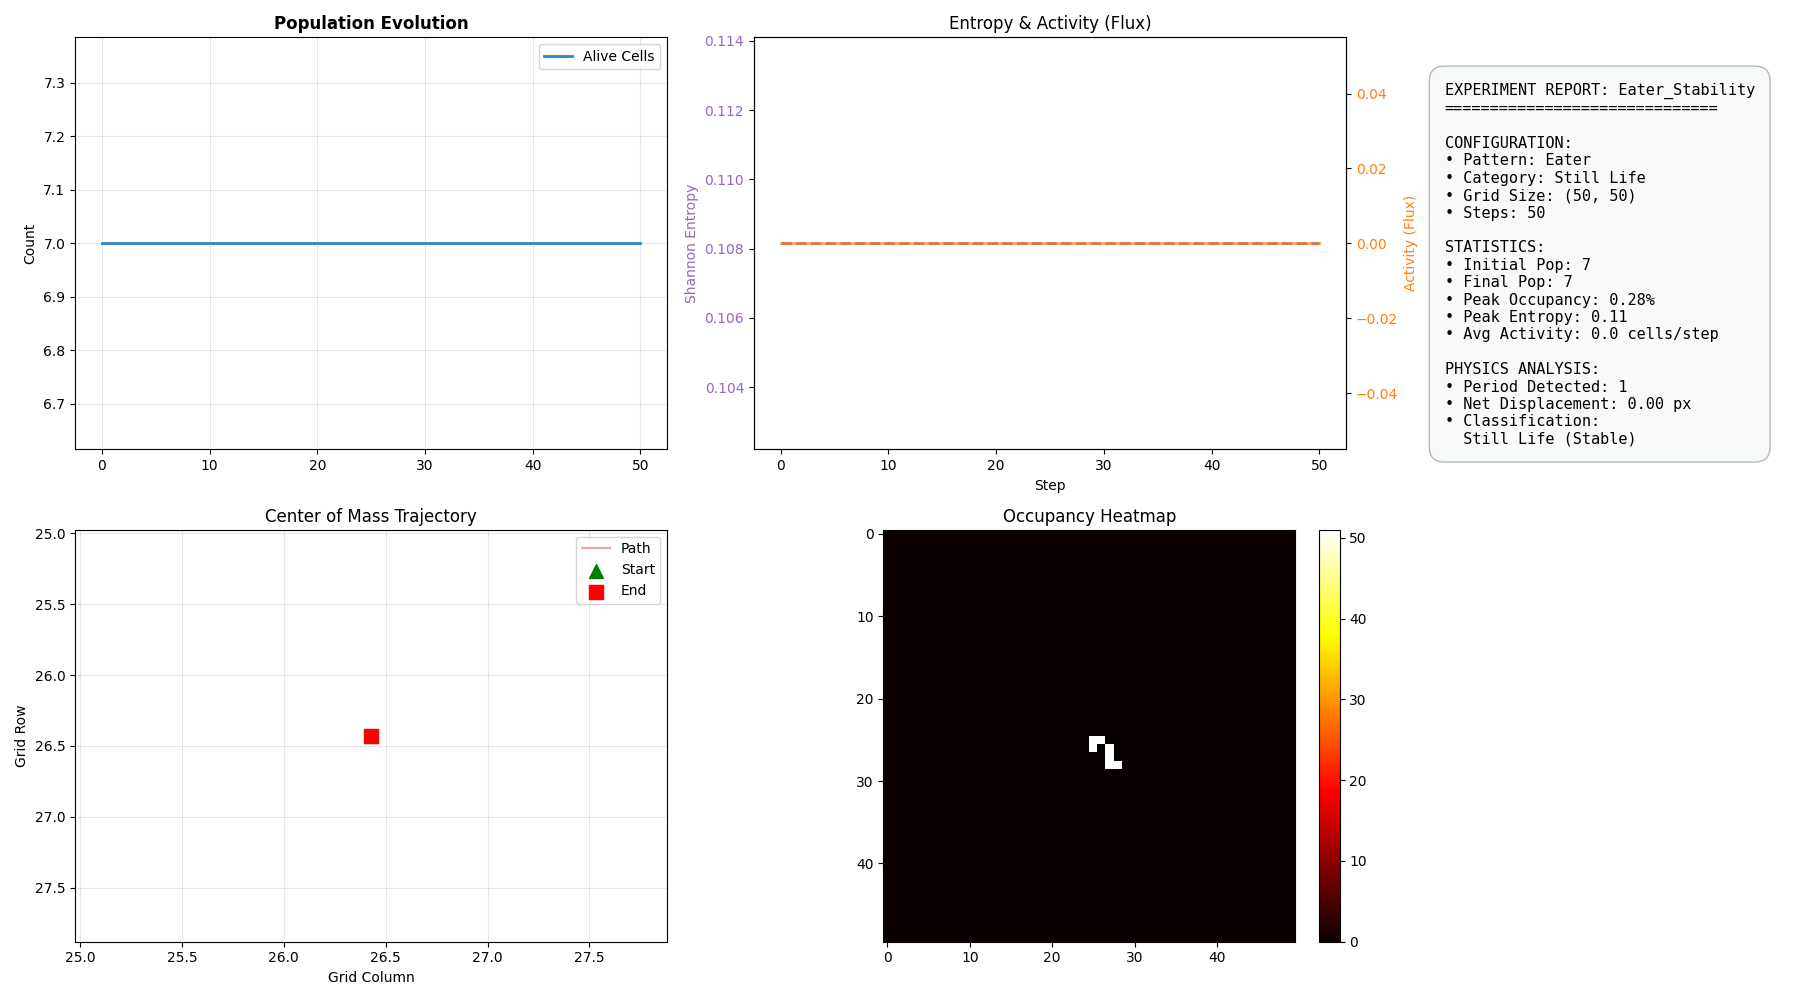


Displaying: report_Glider_Trajectory.png


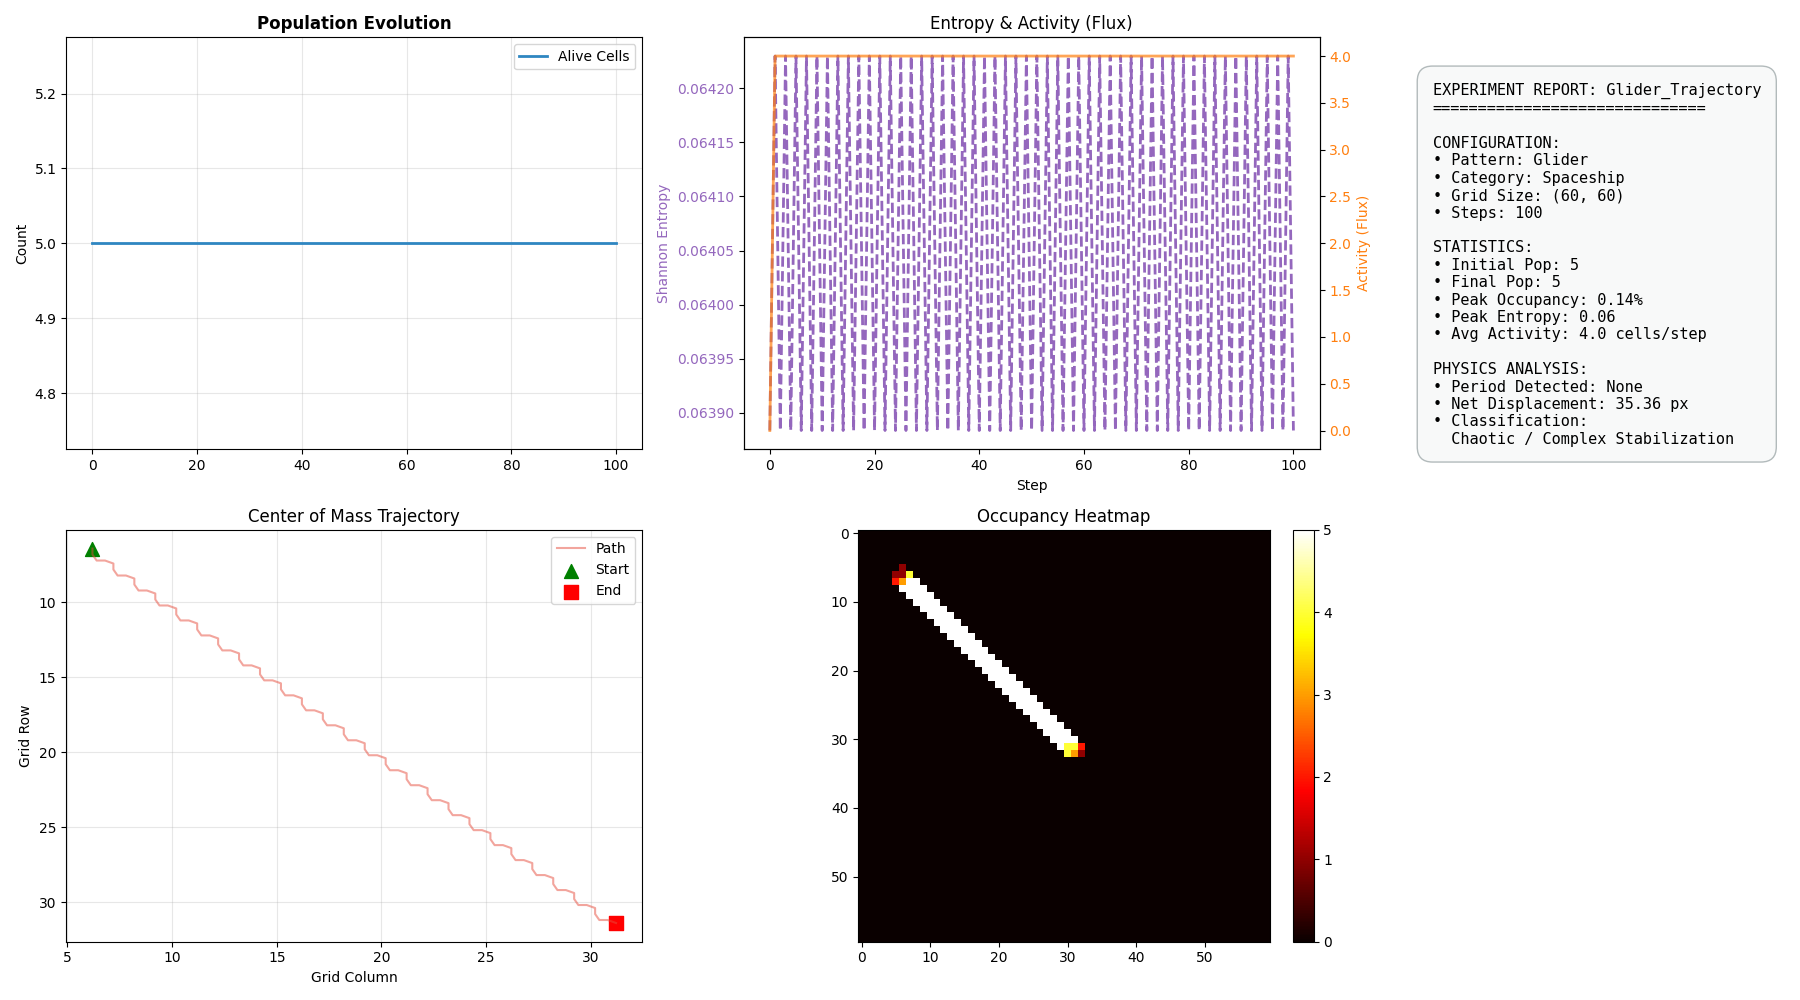


Displaying: report_Loaf_Stability.png


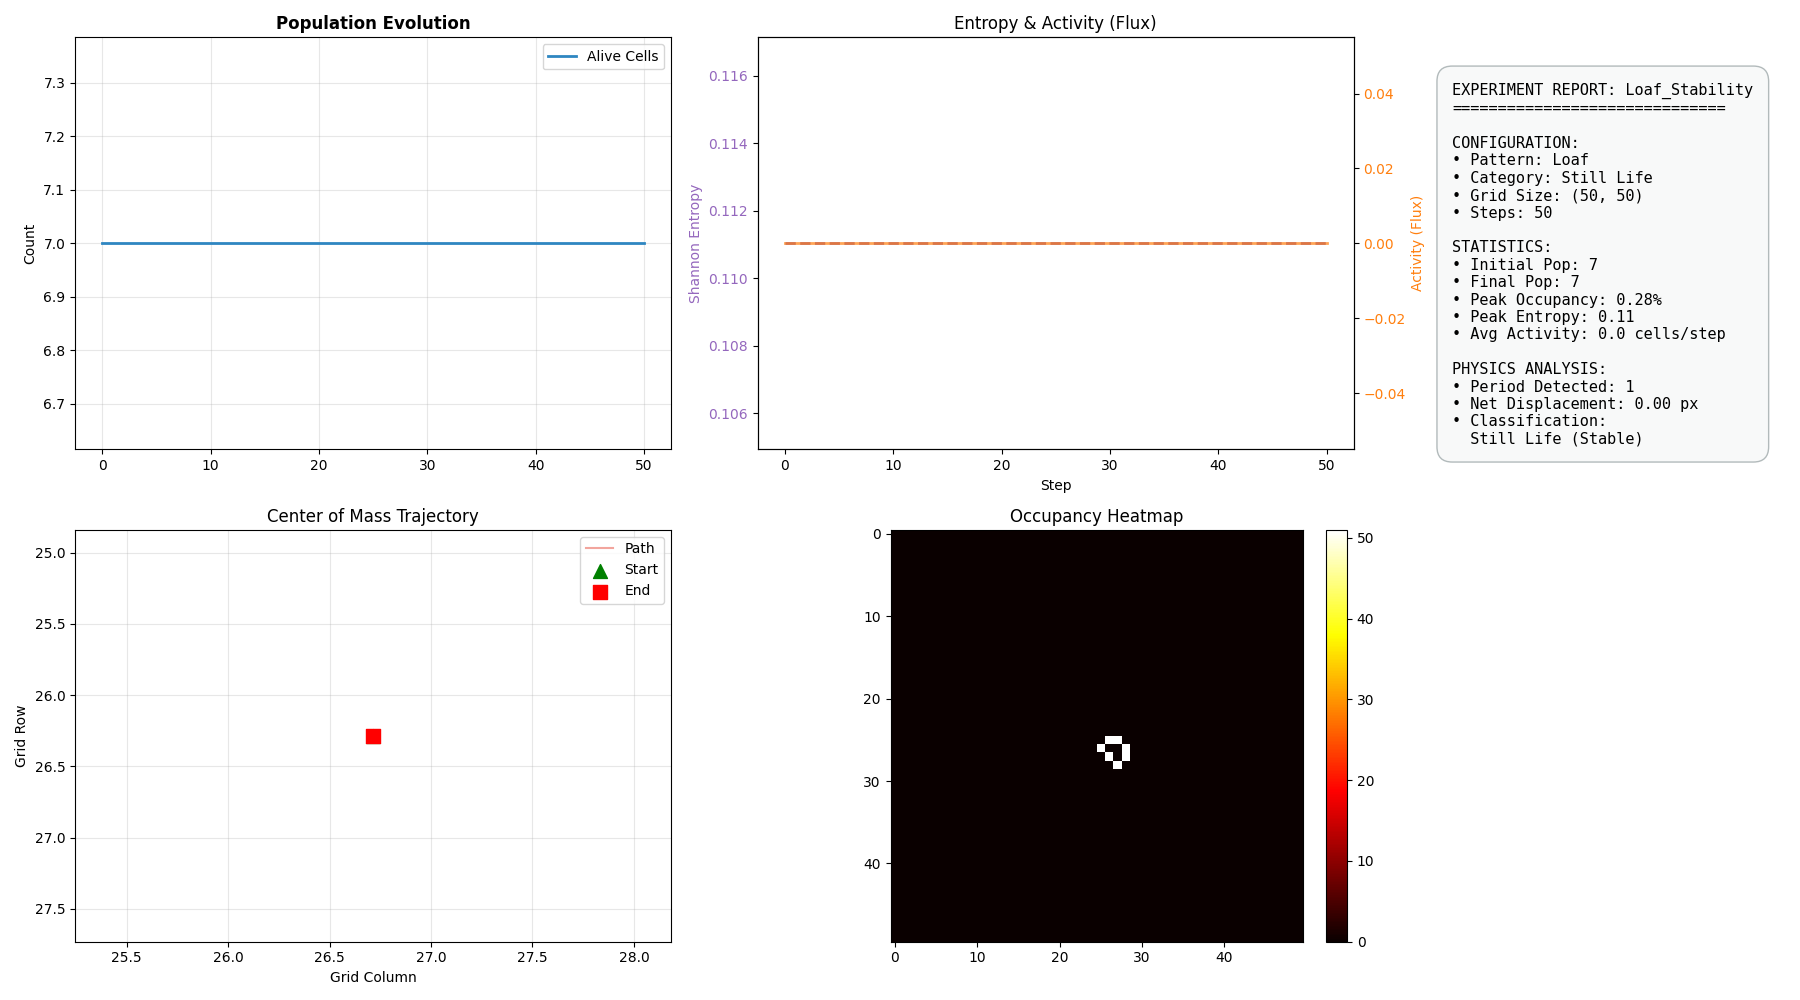


Displaying: report_LWSS_Trajectory.png


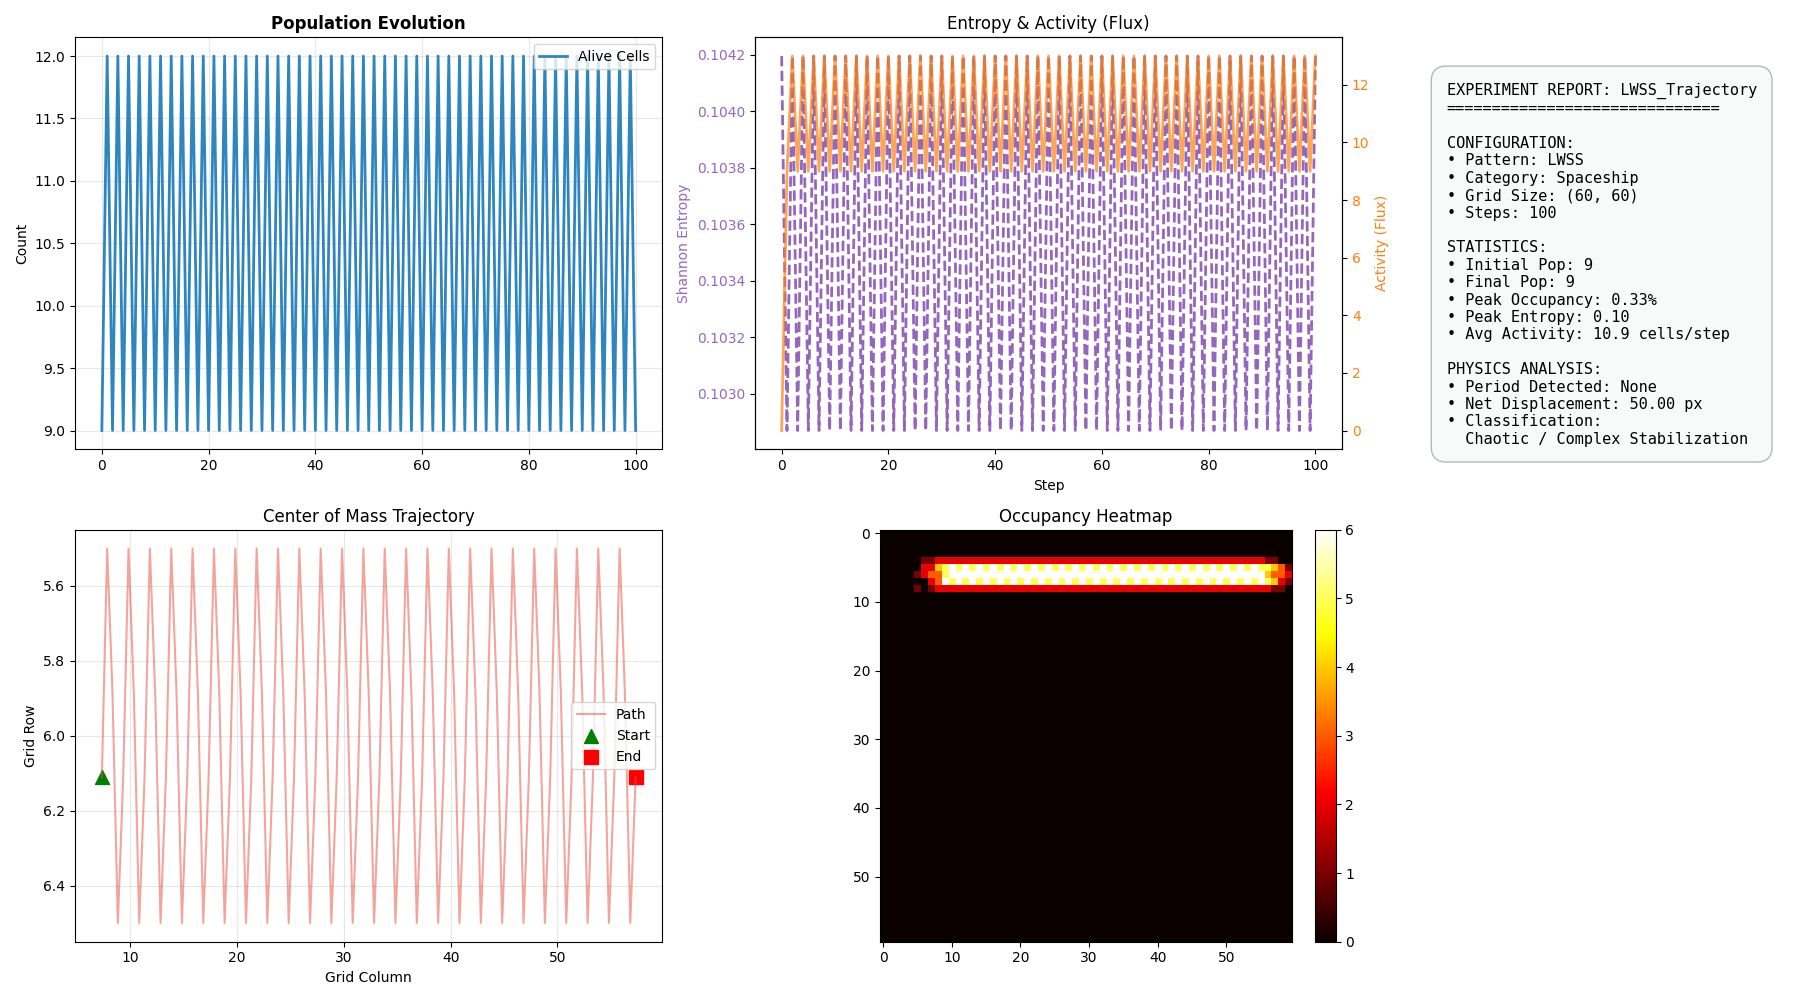


Displaying: report_Toad_Oscillation.png


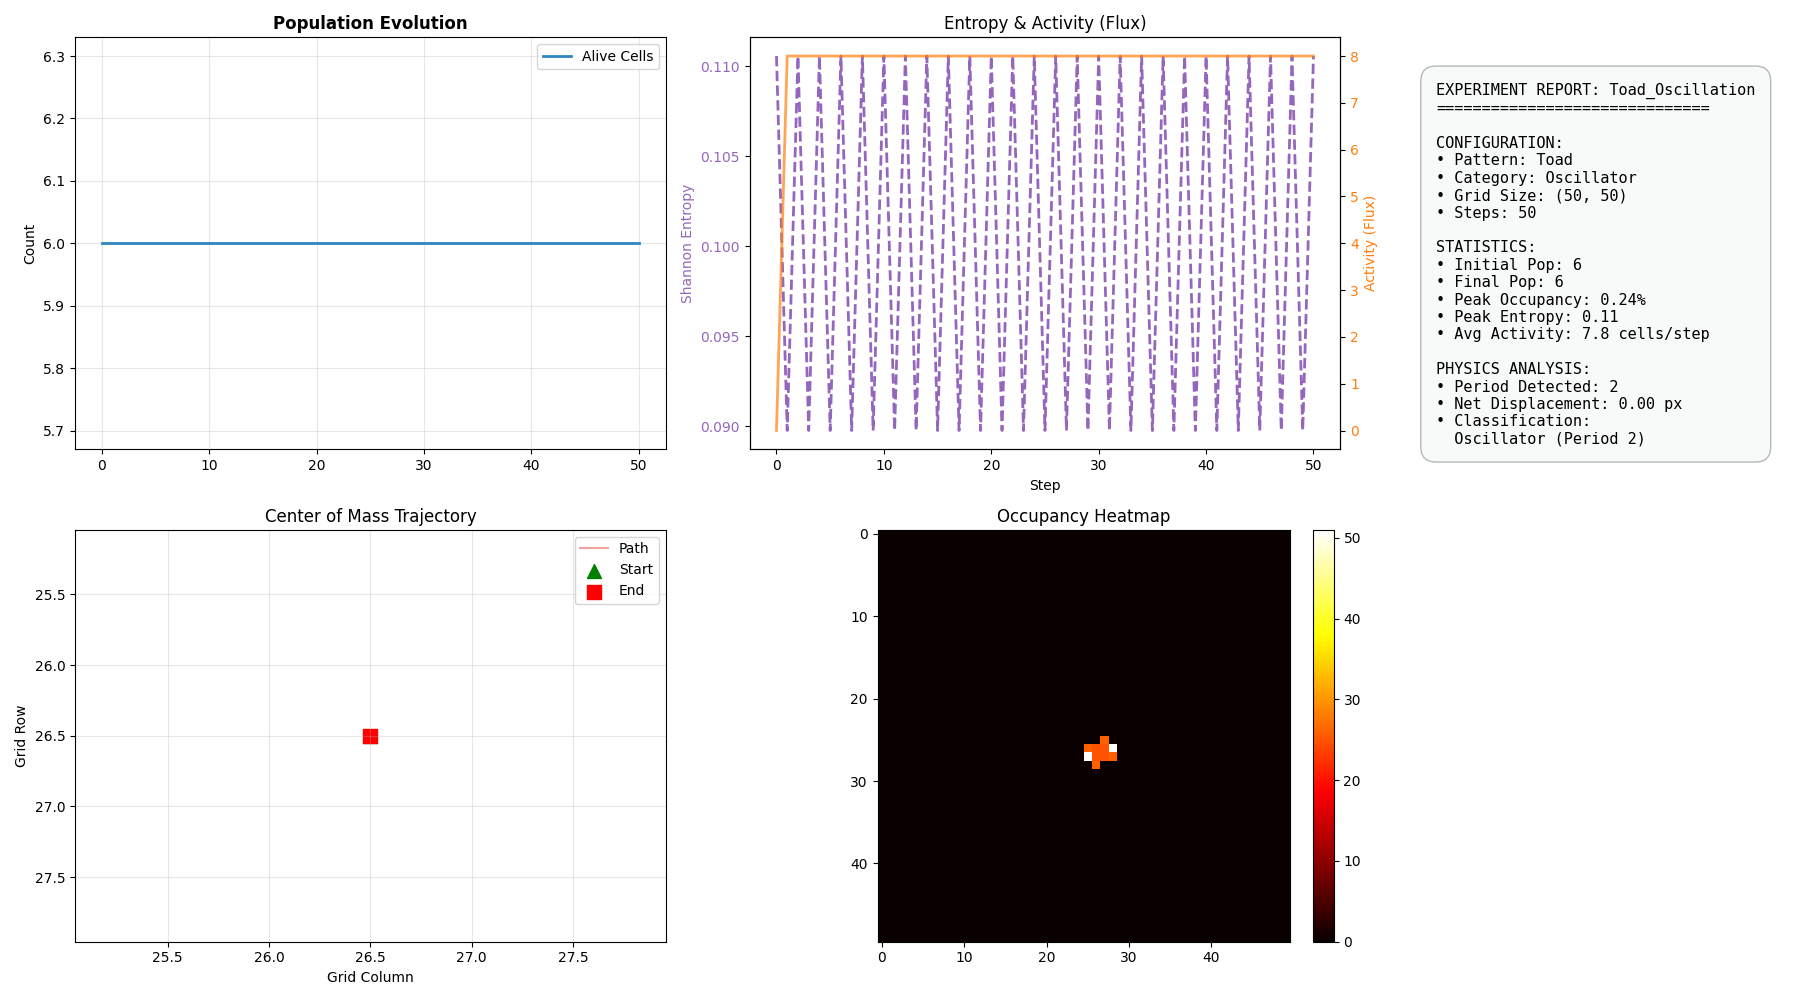


Displaying: report_Pulsar_Oscillation.png


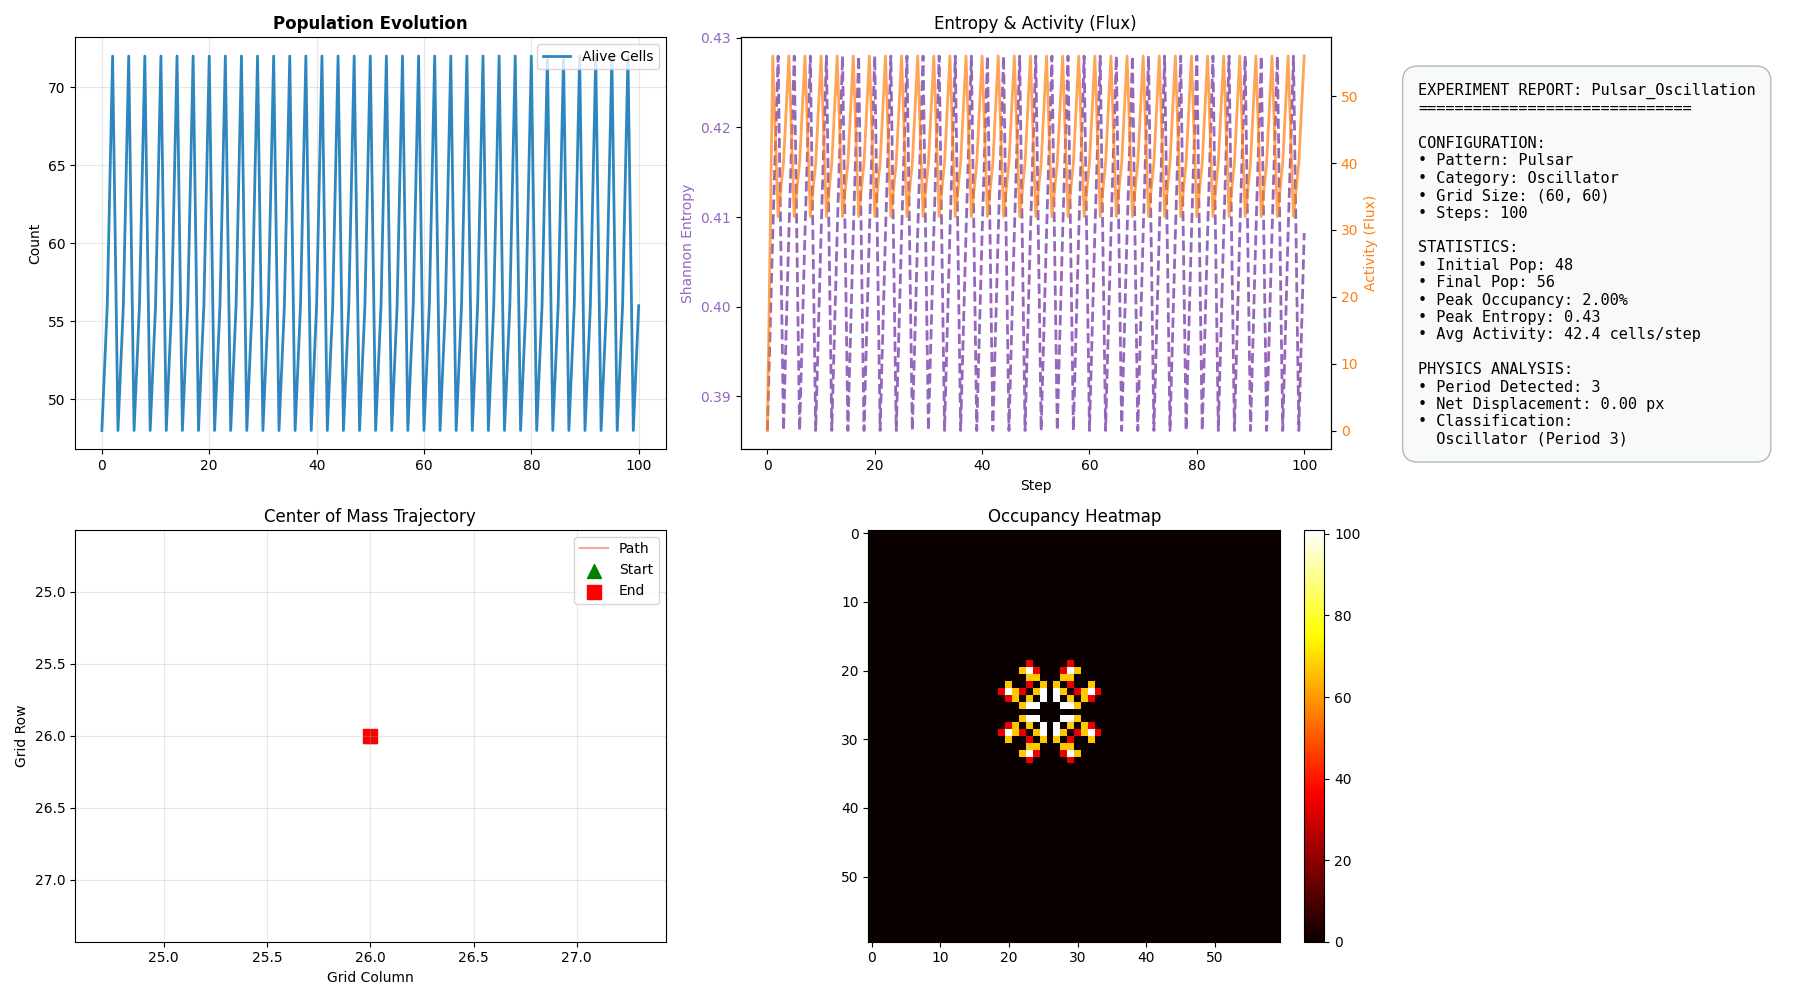


Displaying: report_Blinker_Oscillation.png


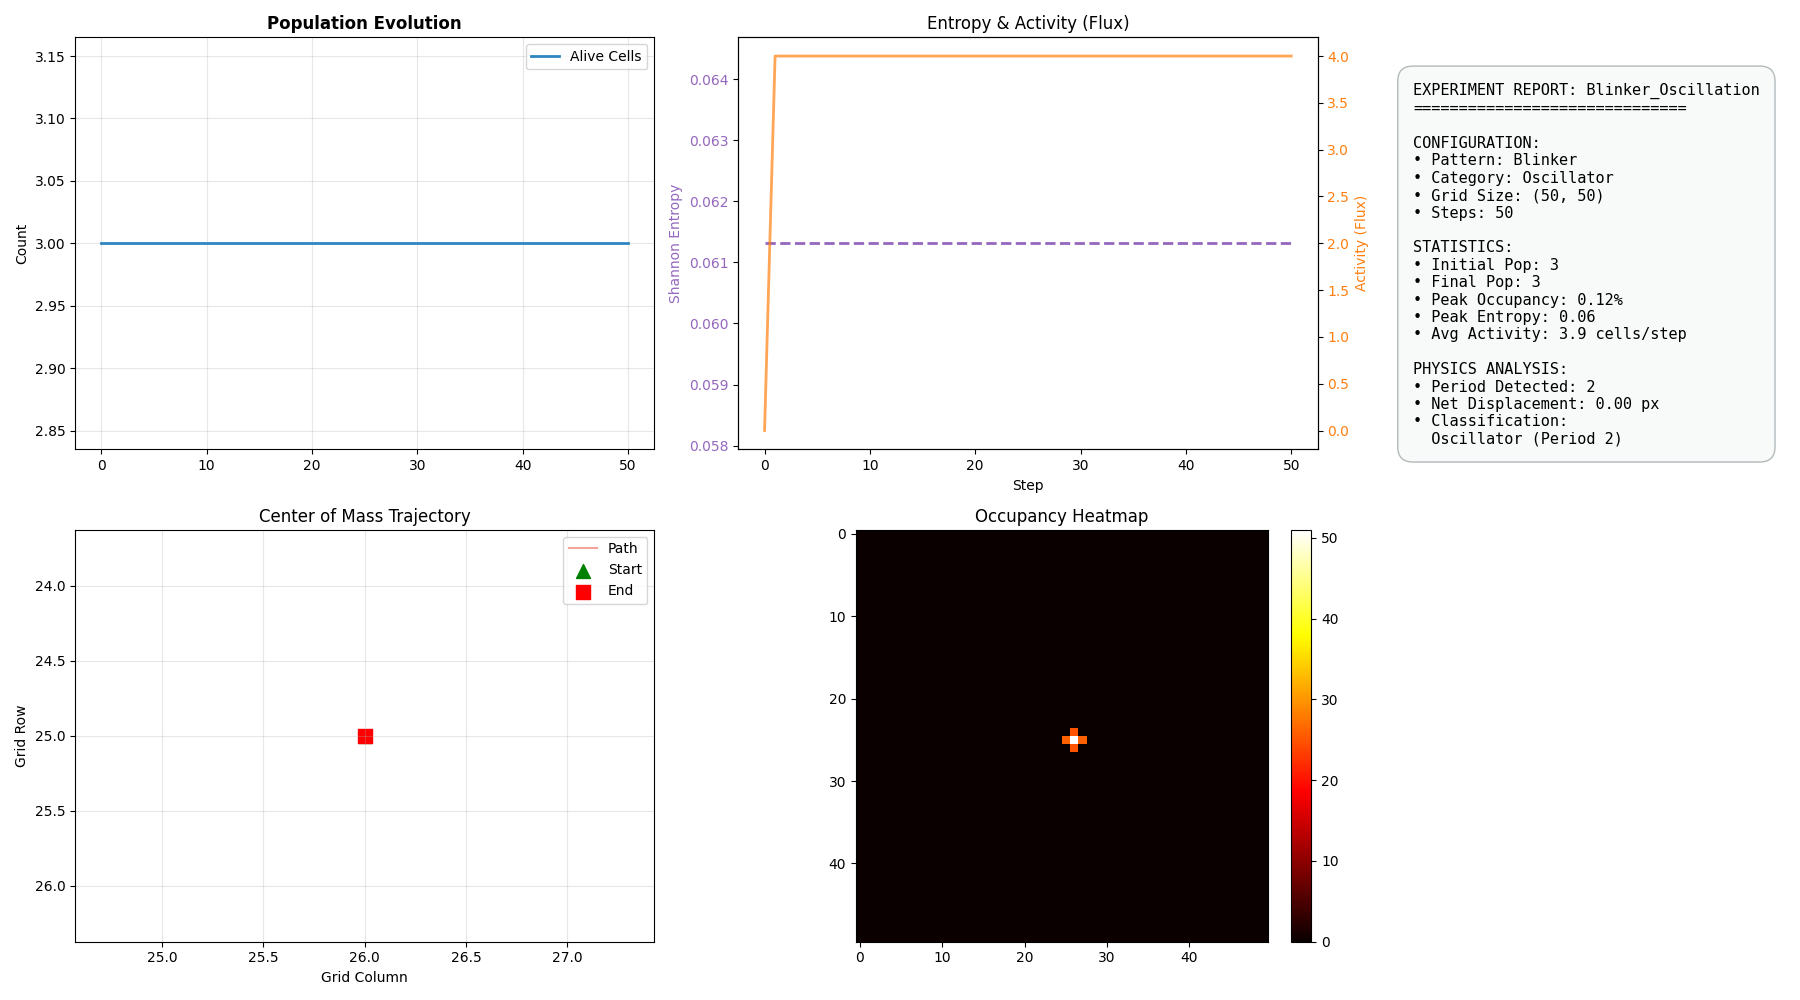


Displaying: report_Breeder_Growth.png


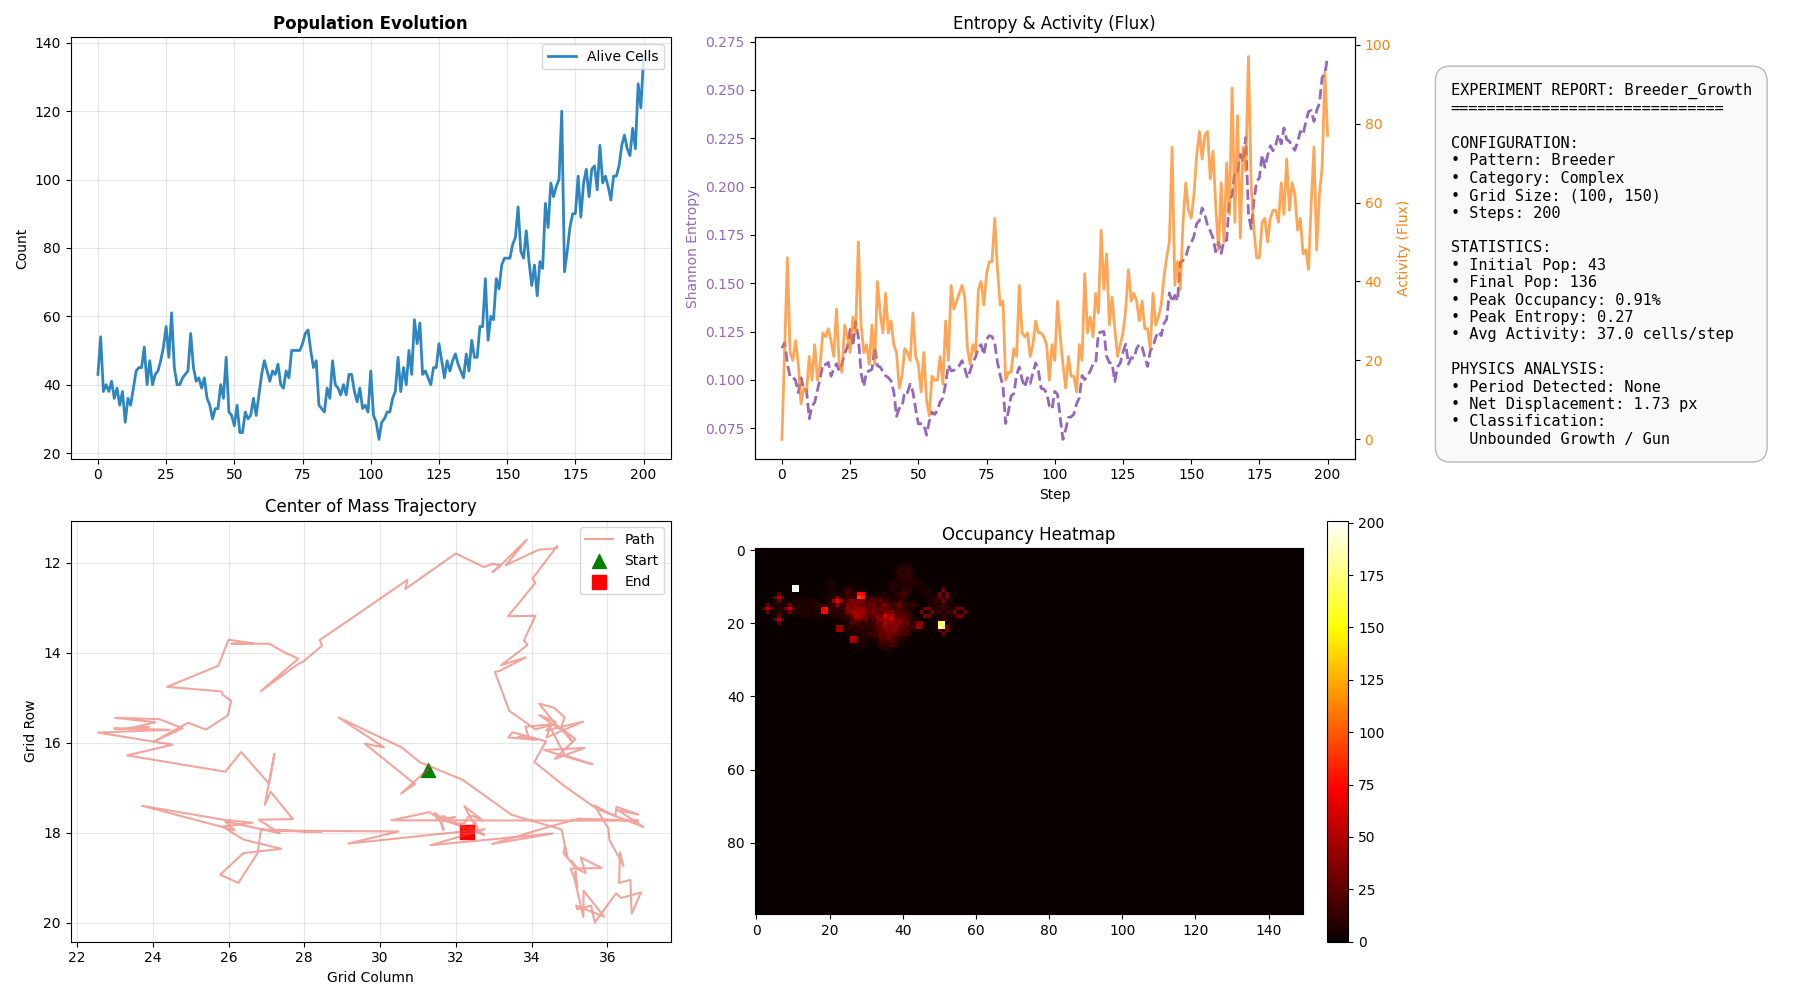


Displaying: report_Random_Entropy.png


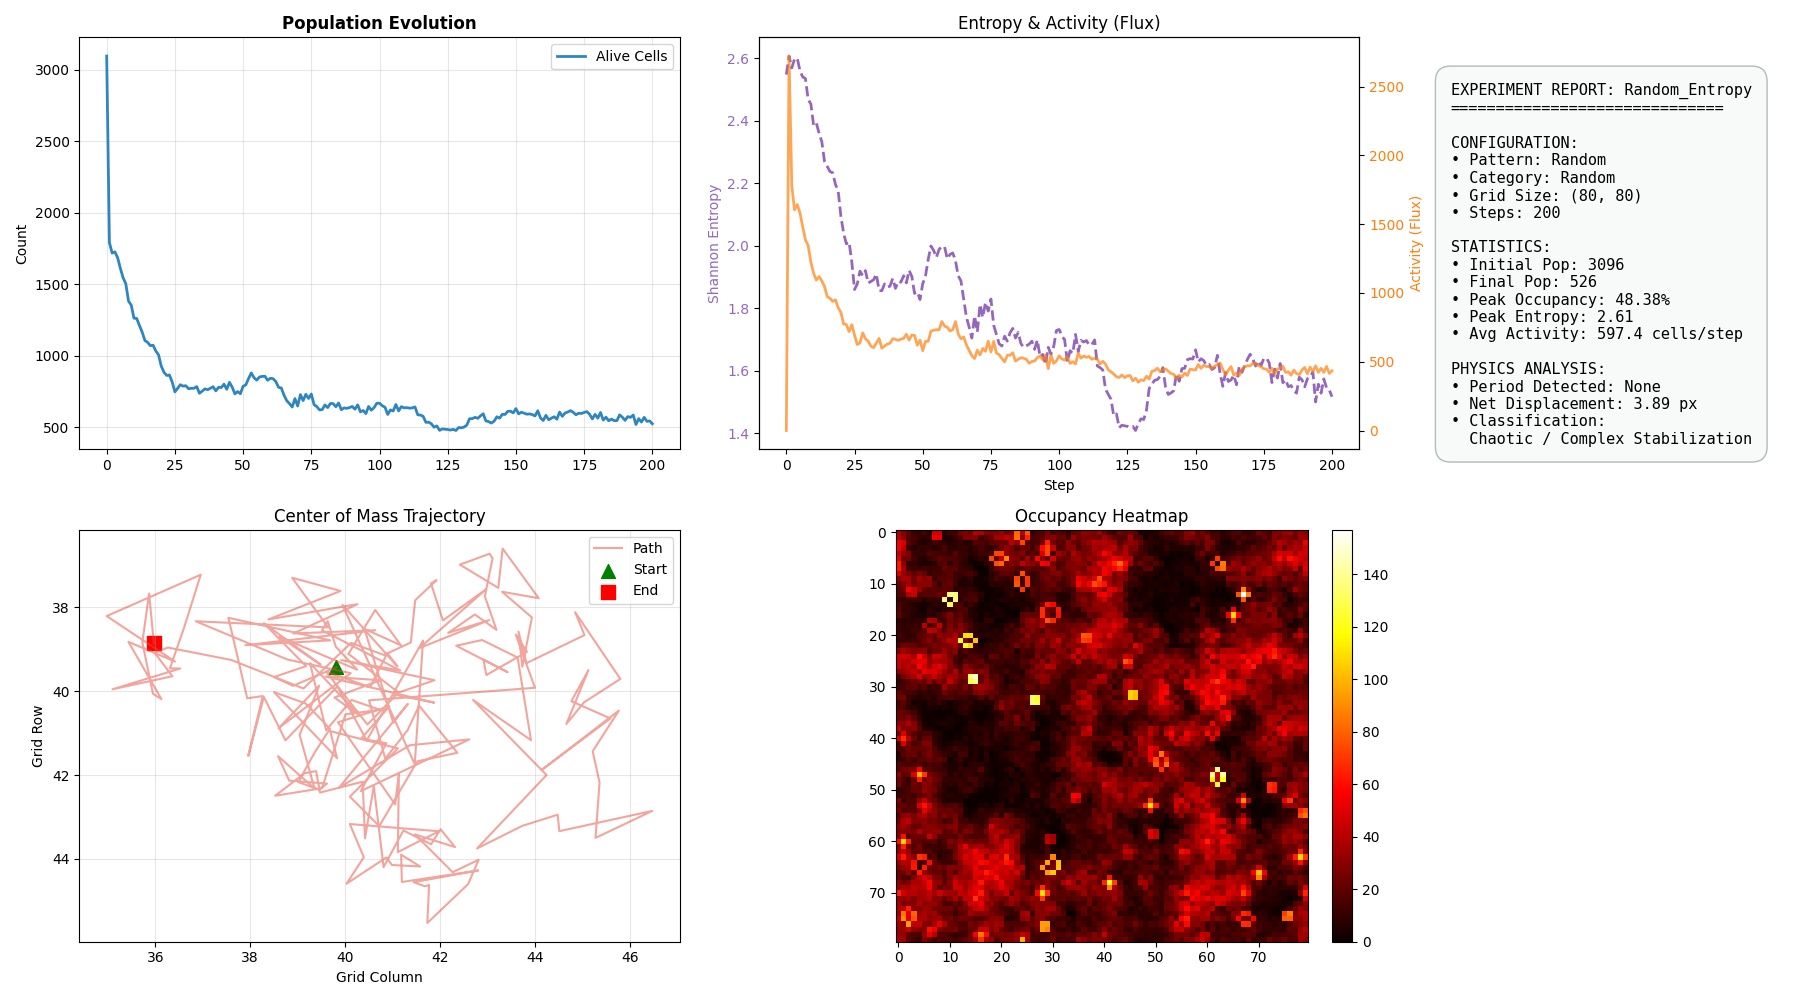


Displaying: report_Beehive_Stability.png


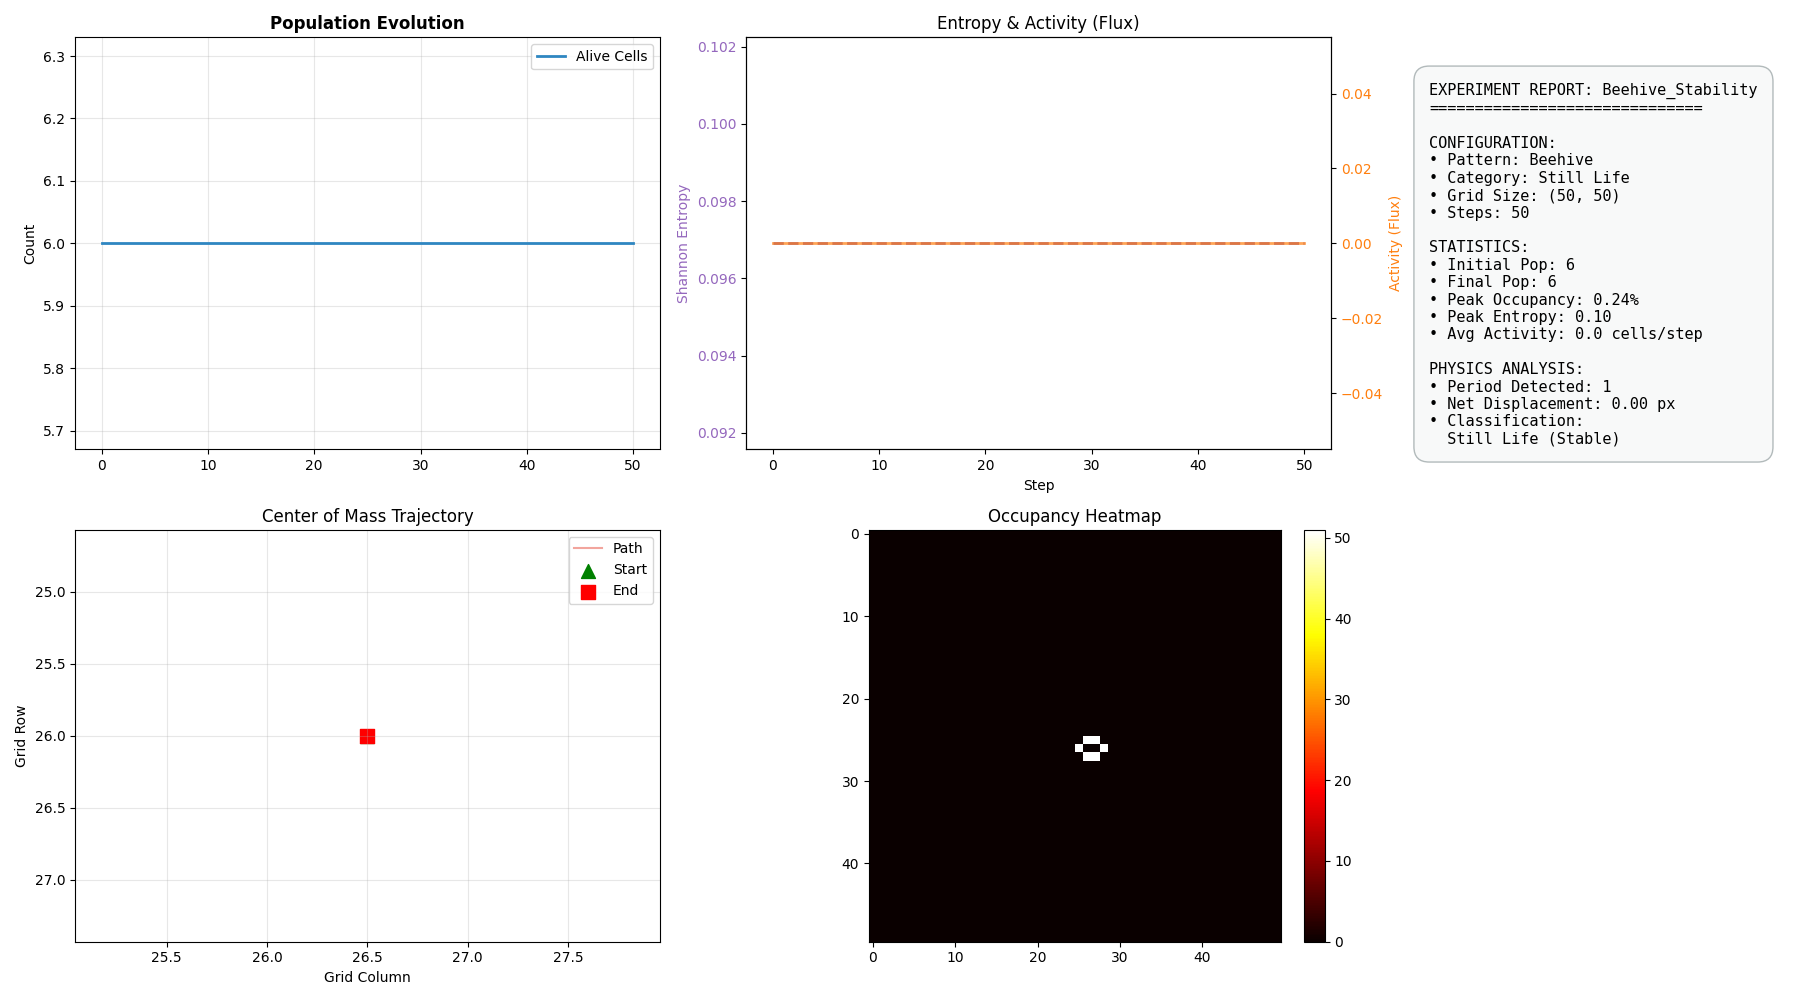


Displaying: report_Gosper_Gun_Growth.png


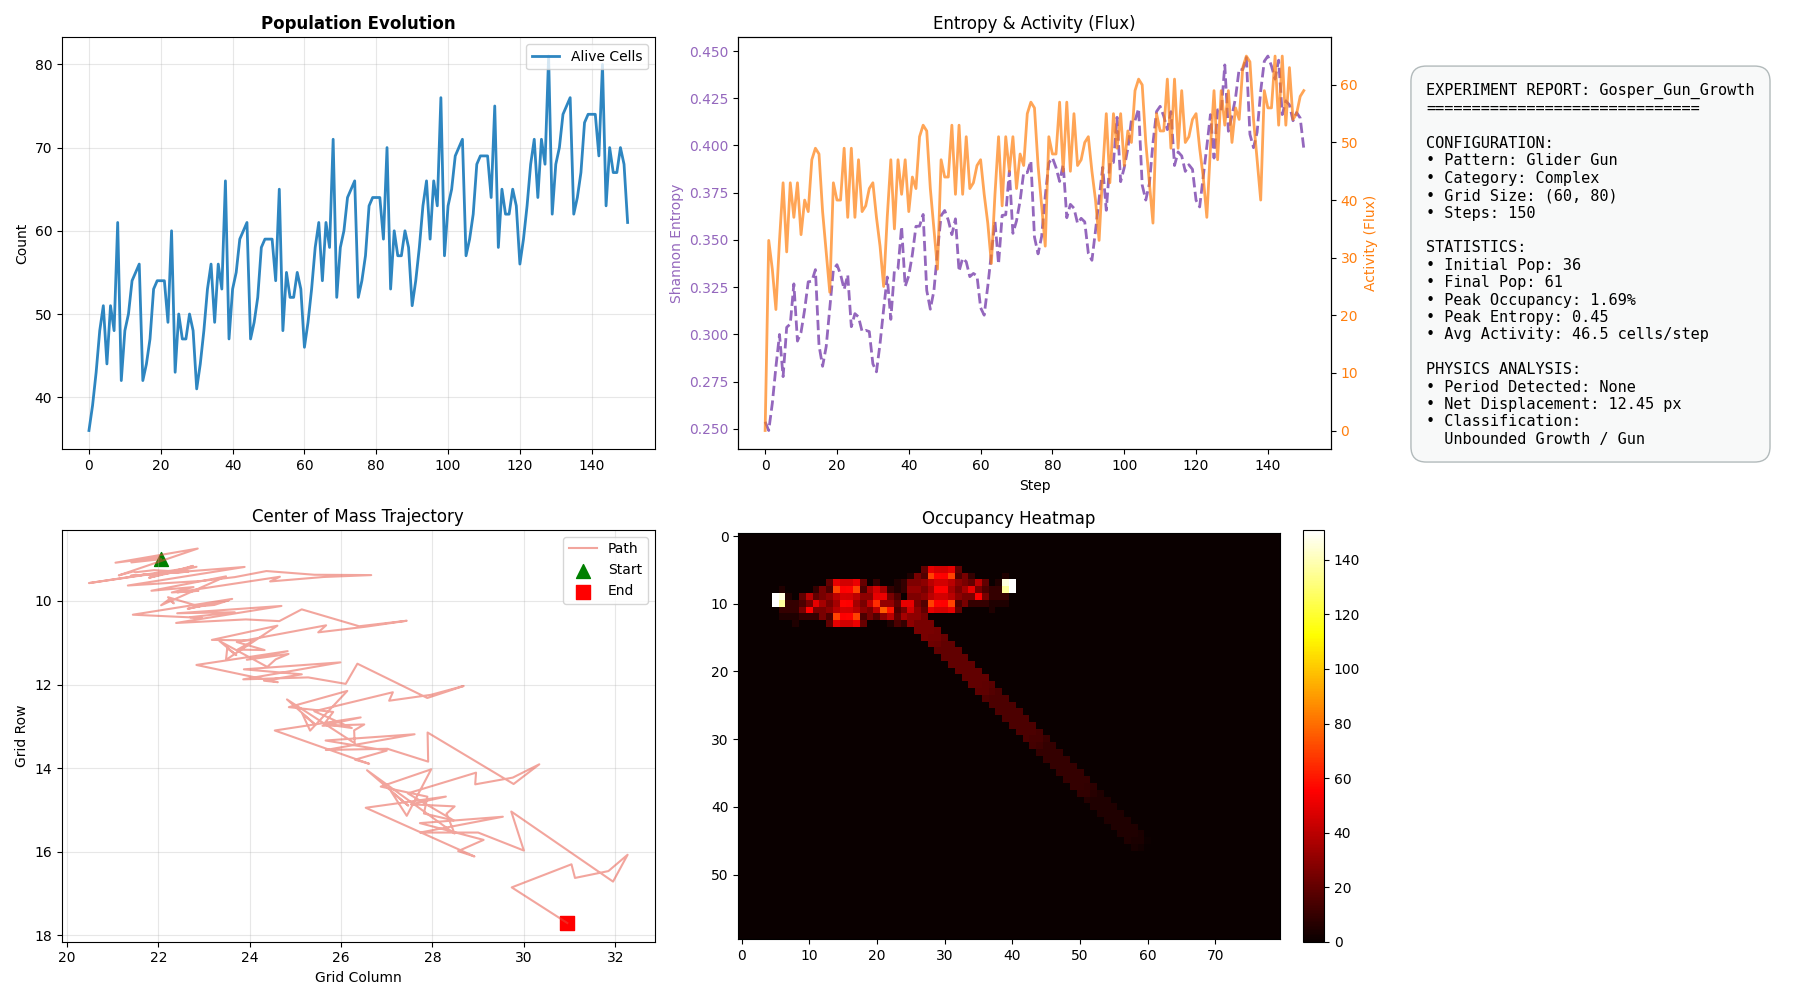


Displaying: report_Pentadecathlon_Oscillation.png


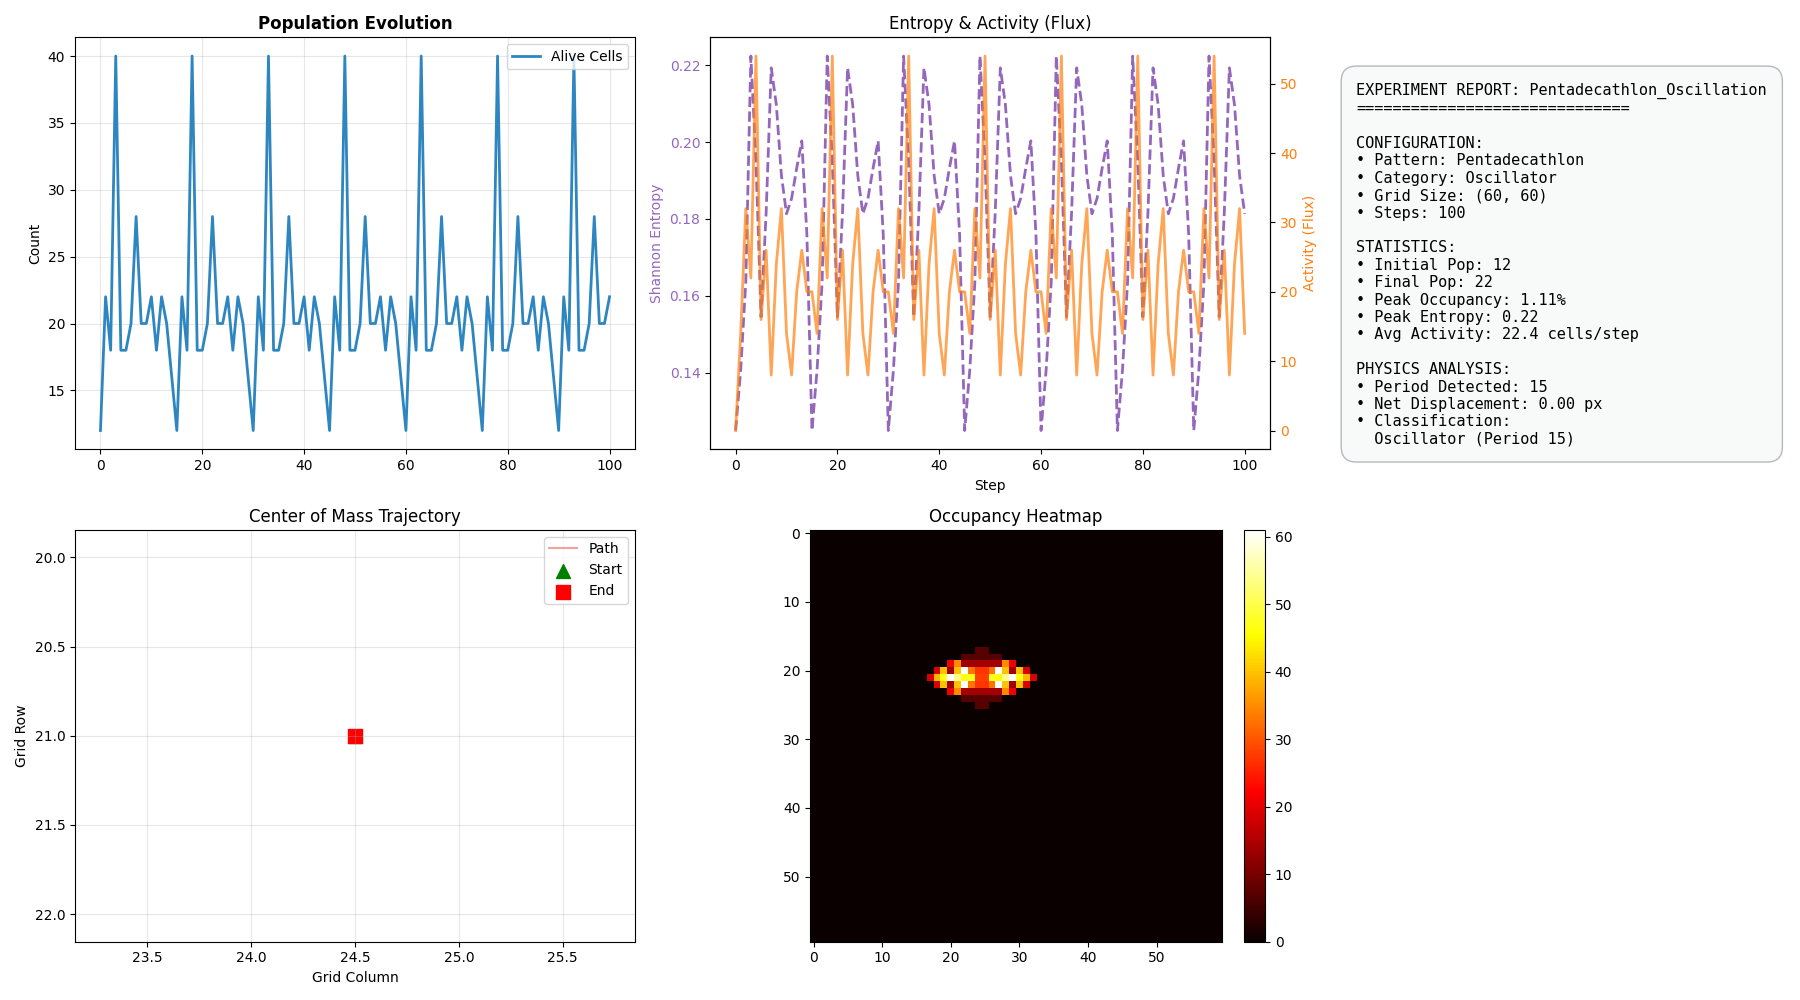


Displaying: report_Block_Stability.png


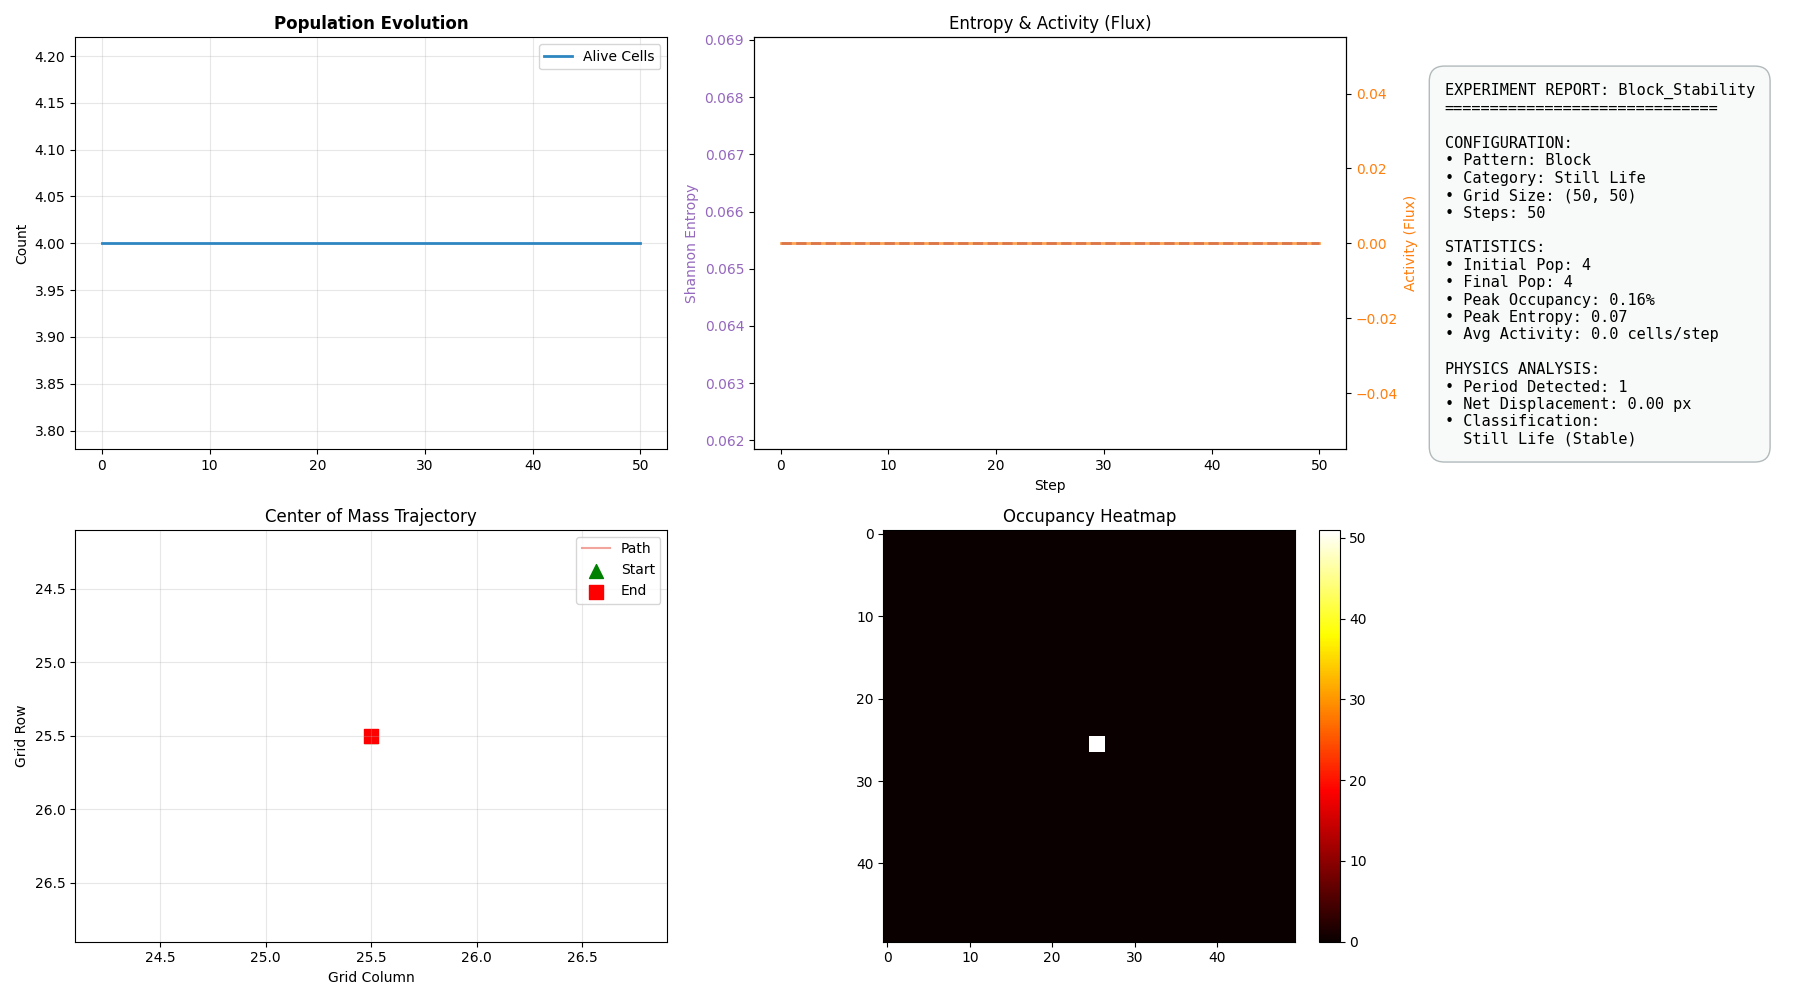

In [12]:
from IPython.display import Image, display
import os

# Define the directory containing the analysis reports
output_dir = "Analysis"

print("Displaying All Analysis Reports:")
print("================================")

# Check if the directory exists
if os.path.exists(output_dir):
    # Iterate through all files in the directory
    for filename in os.listdir(output_dir):
        # Filter for PNG files
        if filename.lower().endswith(".png"):
            filepath = os.path.join(output_dir, filename)
            
            print(f"\nDisplaying: {filename}")
            display(Image(filename=filepath))
else:
    print(f"Error: The directory '{output_dir}' does not exist.")